In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx

In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()


In [3]:
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing       ...         \
anime_id                                          ...          
11013           12  Finished Airing   False       ...          
2104            26  Finished Airing   False       ...          
5262            51  Finished Airing   False       ...          
721             38  Finished Airing   False       ...          
12365           25  Finished Airing   False       ...          

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning G

In [7]:
animes.columns

Index(['title', 'title_english', 'title_japanese', 'title_synonyms',
       'image_url', 'type', 'source', 'episodes', 'status', 'airing',
       'aired_string', 'aired', 'duration', 'rating', 'score', 'scored_by',
       'rank', 'popularity', 'members', 'favorites', 'background', 'premiered',
       'broadcast', 'related', 'producer', 'licensor', 'studios', 'genres',
       'opening_theme', 'ending_theme', 'duration_min', 'aired_from_year'],
      dtype='object')

In [8]:
animes[['title', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studios',
       'genres', 'opening_theme', 'ending_theme', 'duration_min']].head()

title type    source  episodes           status  \
anime_id                                                                  
11013           Inu x Boku SS   TV     Manga        12  Finished Airing   
2104         Seto no Hanayome   TV     Manga        26  Finished Airing   
5262       Shugo Chara!! Doki   TV     Manga        51  Finished Airing   
721             Princess Tutu   TV  Original        38  Finished Airing   
12365     Bakuman. 3rd Season   TV     Manga        25  Finished Airing   

          airing                  aired_string  \
anime_id                                         
11013      False  Jan 13, 2012 to Mar 30, 2012   
2104       False    Apr 2, 2007 to Oct 1, 2007   
5262       False   Oct 4, 2008 to Sep 25, 2009   
721        False  Aug 16, 2002 to May 23, 2003   
12365      False   Oct 6, 2012 to Mar 30, 2013   

                                               aired         duration  \
anime_id                                                                
11013     {'from': '2012-01-13', 'to': '2012-03-30'}  24 min. per ep.   
2104      {'from': '2007-04-02', 'to': '2007-10-01'}  24 min. per ep.   
5262      {'from': '2008-10-04', 'to': '2009-09-25'}  24 min. per ep.   
721       {'from': '2002-08-16', 'to': '2003-05-23'}  16 min. per ep.   
12365     {'from': '2012-10-06', 'to': '2013-03-30'}  24 min. per ep.   

                                                 background    premiered  \
anime_id                                                                   
11013     Inu x Boku SS was licensed by Sentai Filmworks...  Winter 2012   
2104                                                    NaN  Spring 2007   
5262                                                    NaN    Fall 2008   
721       Princess Tutu aired in two parts. The first pa...  Summer 2002   
12365                                                   NaN    Fall 2012   

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsu

In [9]:
animes['aired_from'] = pd.to_datetime(animes['aired'].apply(lambda x: ast.literal_eval(x.replace('\'', '"'))['from']), errors='coerce')

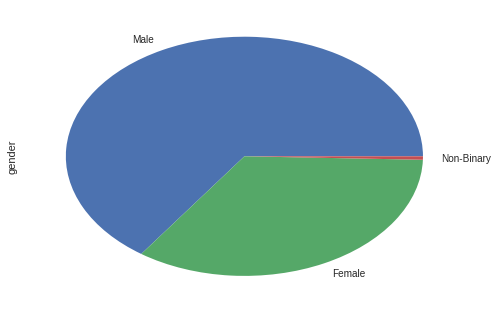

In [10]:
users['gender'].value_counts().plot.pie()

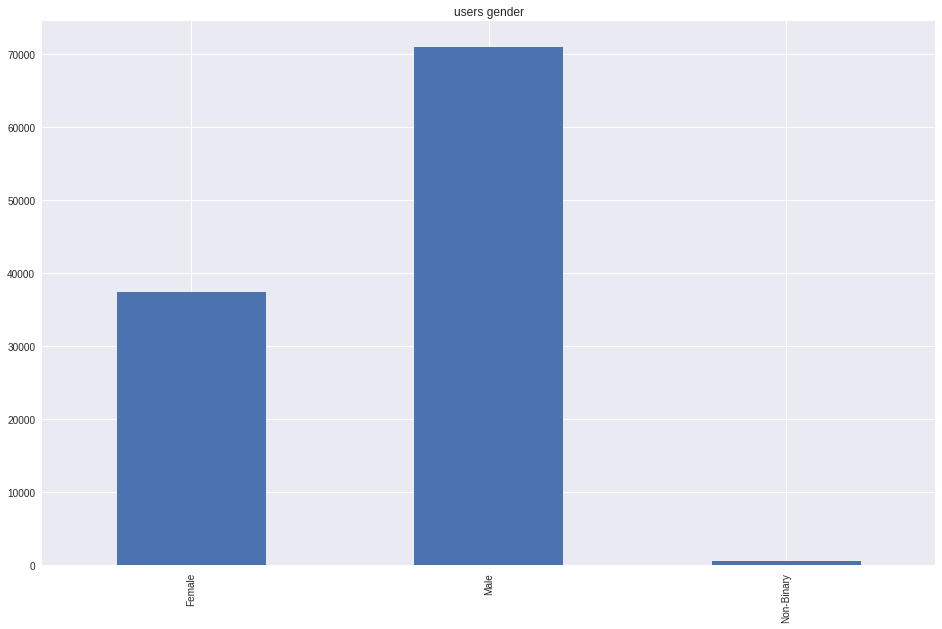

In [11]:
users['gender'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users gender')

In [12]:
users['age'] = 2018 - users['birth_date'].dt.year

In [13]:
print(users['age'].min())
print(users['age'].max())


10
49


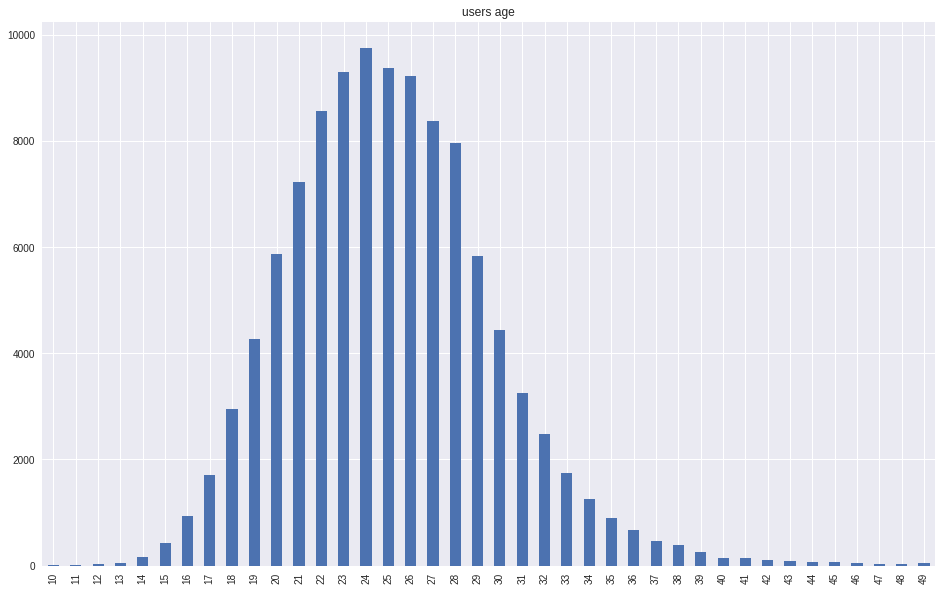

In [14]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age')

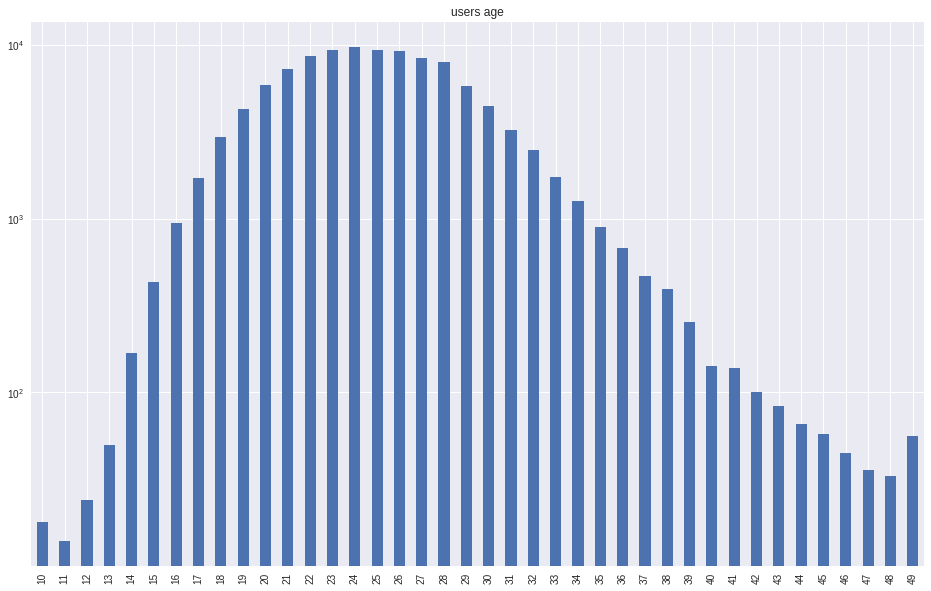

In [15]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age', logy=True)

In [16]:
users['age'].describe()

count    108711.000000
mean         25.125820
std           4.632399
min          10.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          49.000000
Name: age, dtype: float64

In [17]:
((users['age'] > 45) | (users['age'] < 10)).sum() / users['age'].count()

0.0015637791943777539

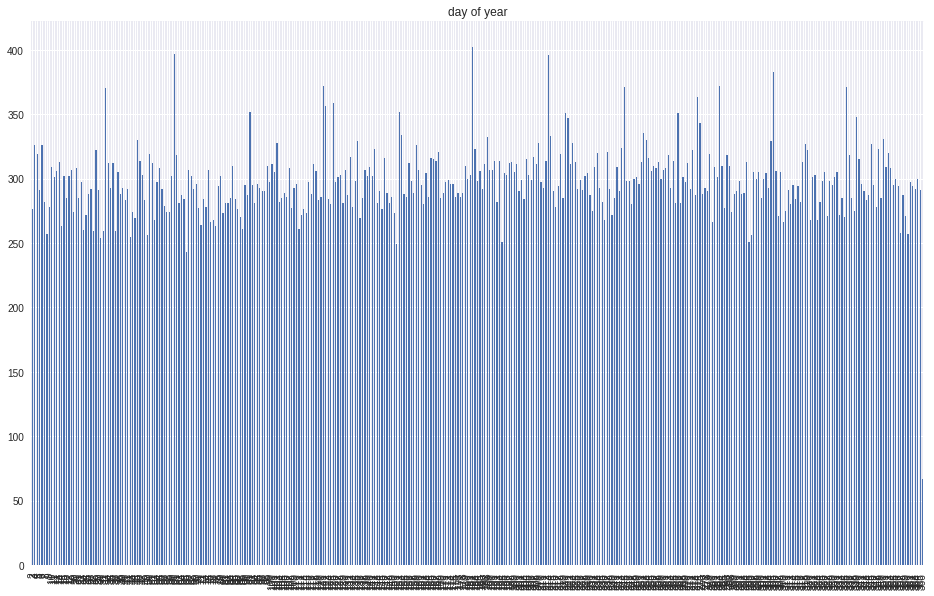

In [18]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year')

In [19]:
display(users[users['birth_date'].dt.dayofyear == 1]['age'].describe())
display(users['age'].describe())


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64

count    108711.000000
mean         25.125820
std           4.632399
min          10.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          49.000000
Name: age, dtype: float64

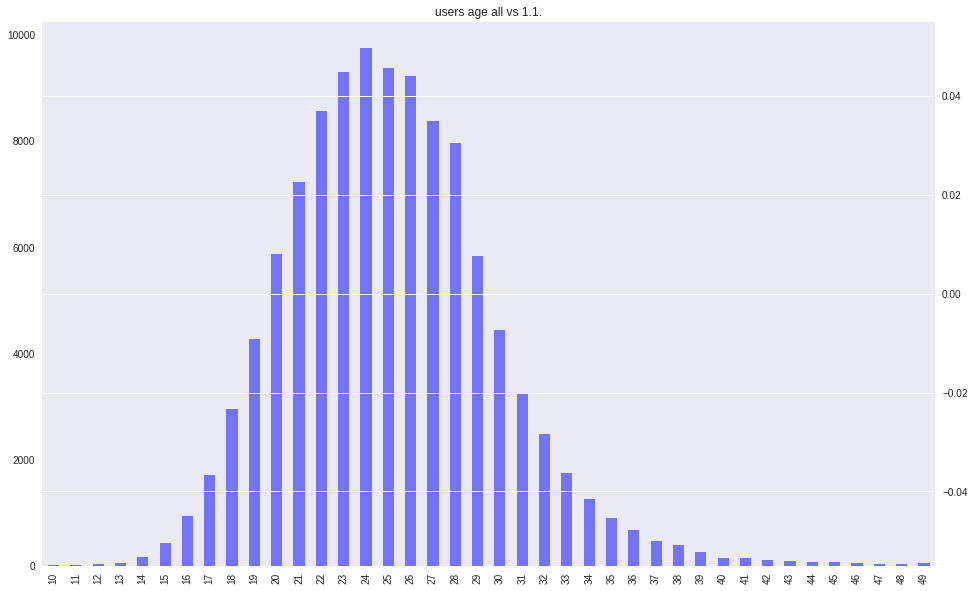

In [20]:
total_count = users['age'].count()
first_jan_count = users[users['birth_date'].dt.dayofyear == 1]['age'].count()
plt.figure(figsize=(16, 10))
ax = plt.gca()

users_in_first_jan = users[users['birth_date'].dt.dayofyear == 1]['age'].value_counts()
users_in_first_jan = users_in_first_jan.reindex(users['age'].value_counts().index)
users['age'].value_counts().sort_index().plot.bar(ax=ax, title='users age all vs 1.1.', color='blue', alpha=0.5)
users_in_first_jan.sort_index().plot.bar(ax=ax, color='red', alpha=0.5, secondary_y=True)
#ax.set_xlim(users['age'].min(), users['age'].max())
#plt.xticks(users['age'].value_counts().index)
plt.show()

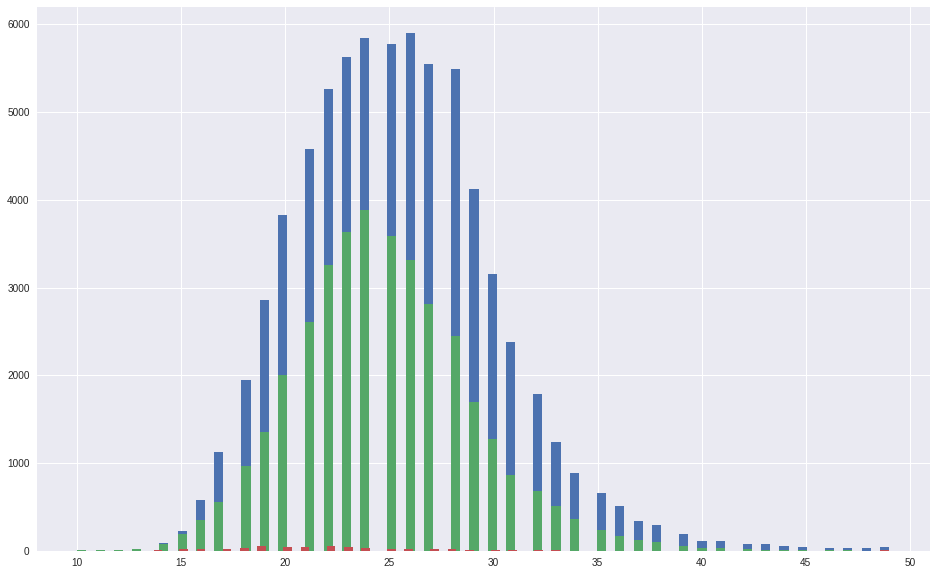

In [21]:
users[users['gender'] == 'Male']['age'].hist(bins=89, figsize=(16,10))
users[users['gender'] == 'Female']['age'].hist(bins=89, figsize=(16,10))
users[users['gender'] == 'Non-Binary']['age'].hist(bins=89, figsize=(16,10))


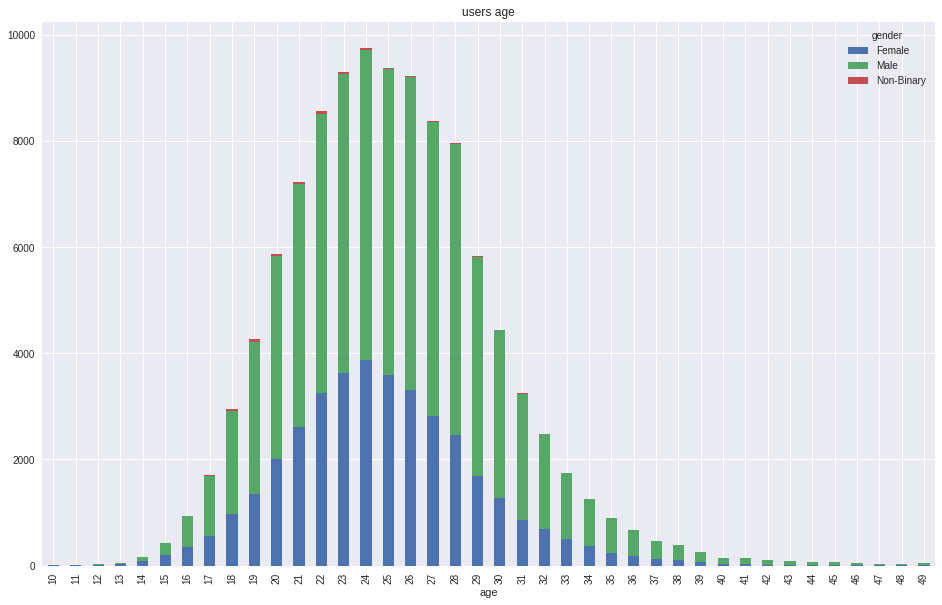

In [22]:
user_gender_age = pd.crosstab(users['age'], users['gender'])
user_gender_age.plot.bar(stacked=True, figsize=(16, 10), title='users age')


In [171]:
# here, in animes_genres, is every anime duplicated, once per each genre it contains
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

In [172]:
genres_arr

genre
anime_id                
11013    0        Comedy
         1  Supernatural
         2       Romance
         3       Shounen
2104     0        Comedy
         1        Parody
         2       Romance
         3        School
         4       Shounen
5262     0        Comedy
         1         Magic
         2        School
         3        Shoujo
721      0        Comedy
         1         Drama
         2         Magic
         3       Romance
         4       Fantasy
12365    0        Comedy
         1         Drama
         2       Romance
         3       Shounen
6586     0          Kids
         1        School
         2        Shoujo
178      0         Magic
         1        Comedy
         2       Romance
         3        School
         4        Shoujo
...                  ...
37619    0       Romance
         1        School
         2        Sports
37858    0        Comedy
37755    0        Comedy
37895    0       Fantasy
37888    0        Action
         1     Adventure
         2        Demons
         3       Fantasy
         4         Magic
37667    0        Horror
         1        Parody
         2  Supernatural
37090    0        Action
         1    SuperPower
         2  Supernatural
36913    0        Comedy
37493    0          Kids
37896    0       Fantasy
37494    0          Kids
37894    0       Fantasy
37405    0        Hentai
37886    0   SliceofLife
         1         Drama
         2       Romance
37255    0         Music
         1          Kids
35229    0          Kids
36315    0          Kids

[23746 rows x 1 columns]

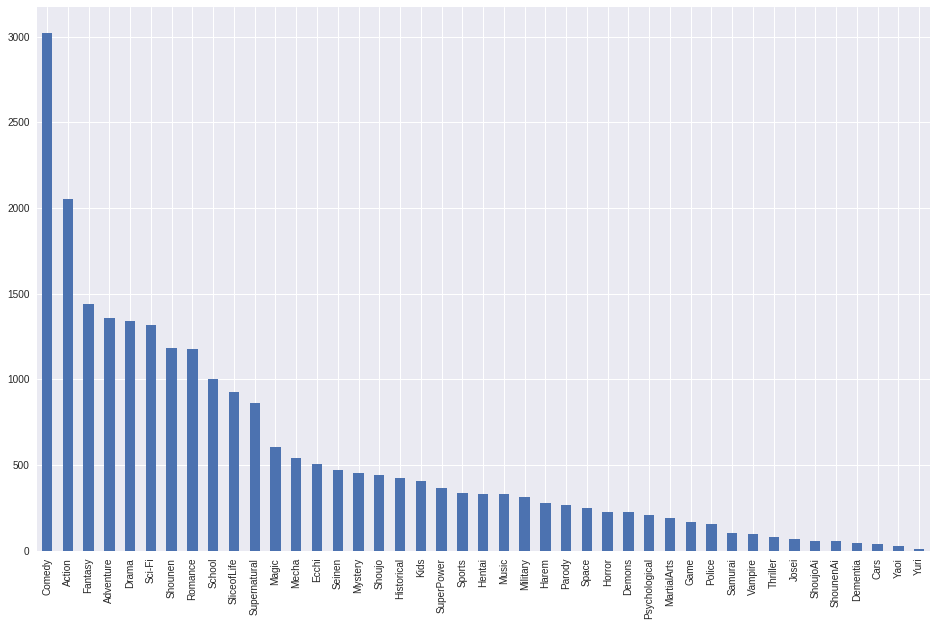

In [173]:
animes_genres['genre'].value_counts().plot(kind='bar', figsize=(16, 10))

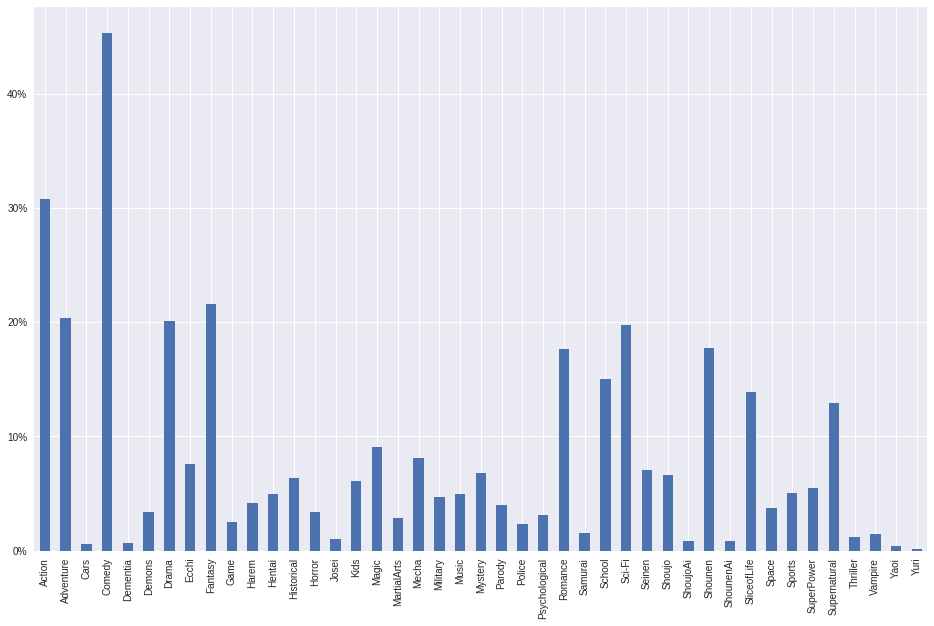

In [174]:
(animes_genres['genre'].value_counts() / animes.shape[0]).sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

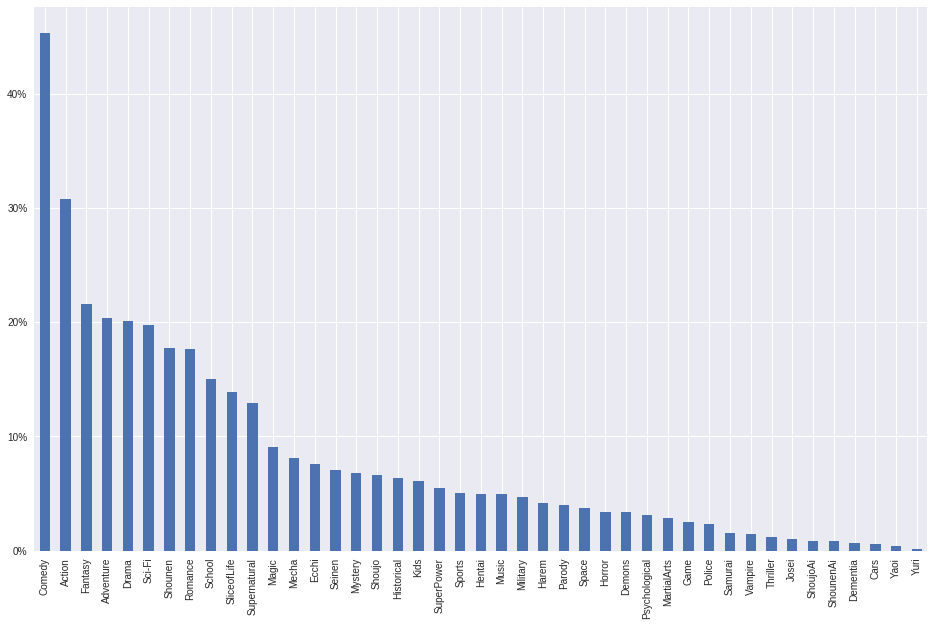

In [176]:
(animes_genres['genre'].value_counts() / animes.shape[0]).plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [34]:
print('total percentage of some genres: ', (genres_occurence[['Yuri', 'Yaoi', 'ShounenAi', 'ShoujoAi']] / animes.shape[0]).sum())
print('total percentage of some genres: ', (genres_occurence[['Yuri', 'Yaoi']] / animes.shape[0]).sum())

total percentage of some genres:  0.022345530893821235
total percentage of some genres:  0.005698860227954409


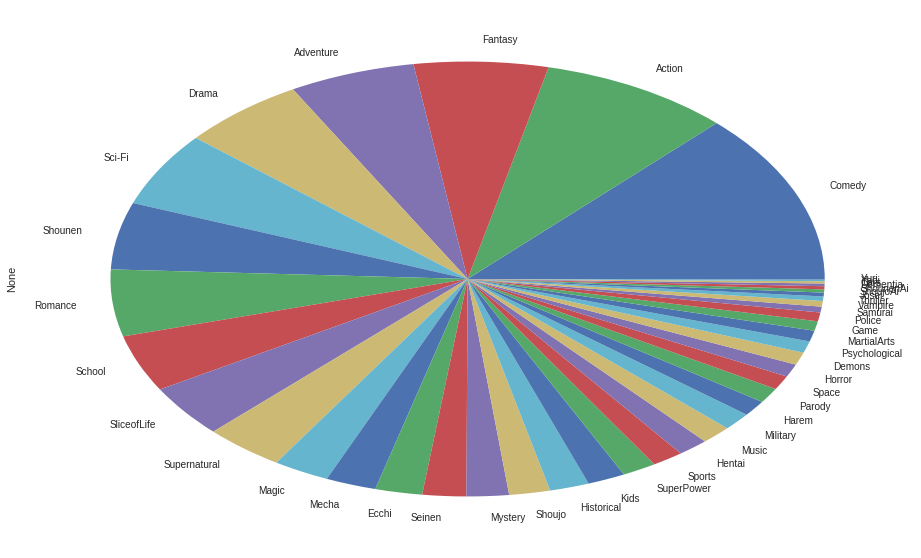

In [35]:
genres.plot.pie(figsize=(16, 10))

In [36]:
genres_years = pd.crosstab(animes['aired_from'].dt.year, animes['genres'])

In [37]:
display(animes['aired_from'].dt.year.describe())
years_diff = int(animes['aired_from'].dt.year.max() - animes['aired_from'].dt.year.min()) + 1
display(years_diff)
anime_aired_year = animes['aired_from'].dt.year.dropna().astype(np.int)

count    6553.000000
mean     2007.028231
std        10.283658
min      1942.000000
25%      2003.000000
50%      2010.000000
75%      2015.000000
max      2018.000000
Name: aired_from, dtype: float64

77

In [38]:
anime_aired_year.plot(kind='hist', bins=years_diff, figsize=(16, 10), title='Anime aired in year')

In [39]:
anime_aired_year.plot(kind='hist', bins=years_diff, figsize=(16, 10), title='Anime aired in year, zommed 2000 - 2018')
plt.gca().set_xlim([2000, 2018])

(2000, 2018)

In [40]:
animes[animes['title'] == 'Usavich']['aired']

anime_id
3737    {'from': '2018-05-12', 'to': '2018-05-12'}
Name: aired, dtype: object

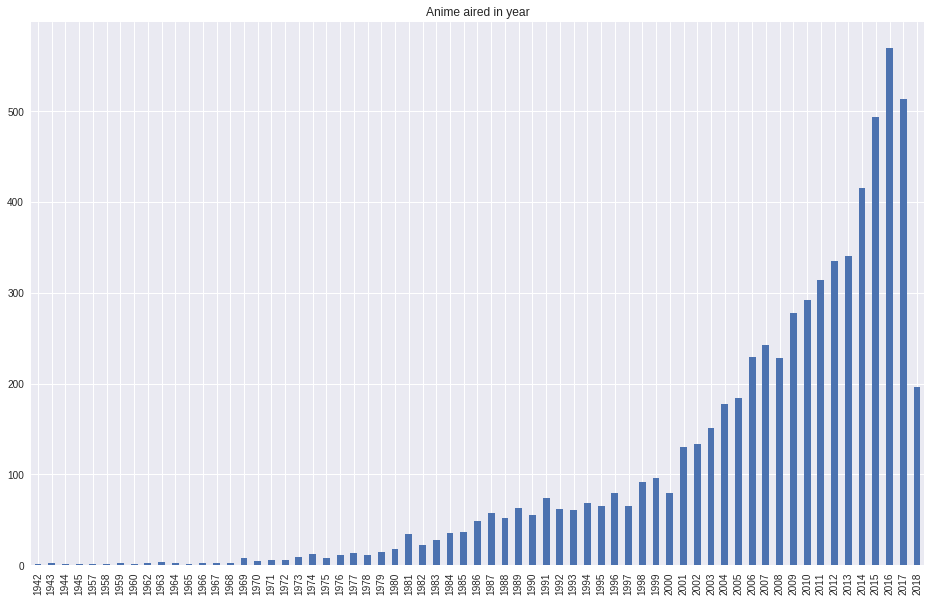

In [41]:
anime_aired_year.value_counts().sort_index().plot.bar(figsize=(16, 10), title='Anime aired in year')

In [42]:
anime_aired_year.value_counts().sort_index().cumsum().plot.bar(figsize=(16, 10), title='Anime aired up to year')

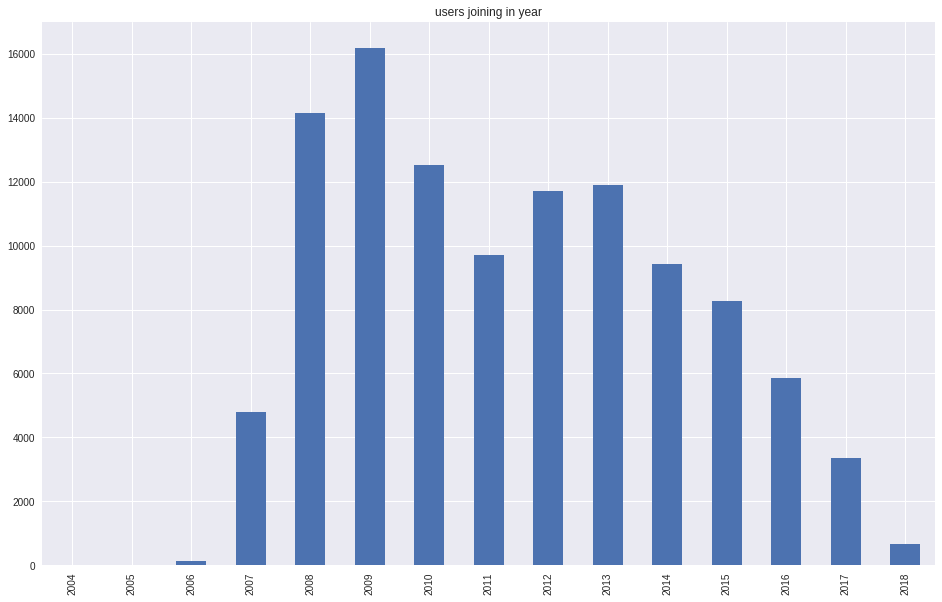

In [43]:
users['join_date'].dt.year.value_counts().sort_index().plot.bar(figsize=(16, 10), title='users joining in year')

In [44]:
users['join_date'].dt.year.value_counts().sort_index().cumsum().plot.bar(figsize=(16, 10), title='total users registered in year')

In [45]:
# counting 0 score, which is not rated, drastically moves both mean and variance
users['rating_mean'] = animelists[animelists['my_score'] != 0].groupby('username')['my_score'].mean()
users['rating_var'] = animelists[animelists['my_score'] != 0].groupby('username')['my_score'].var()

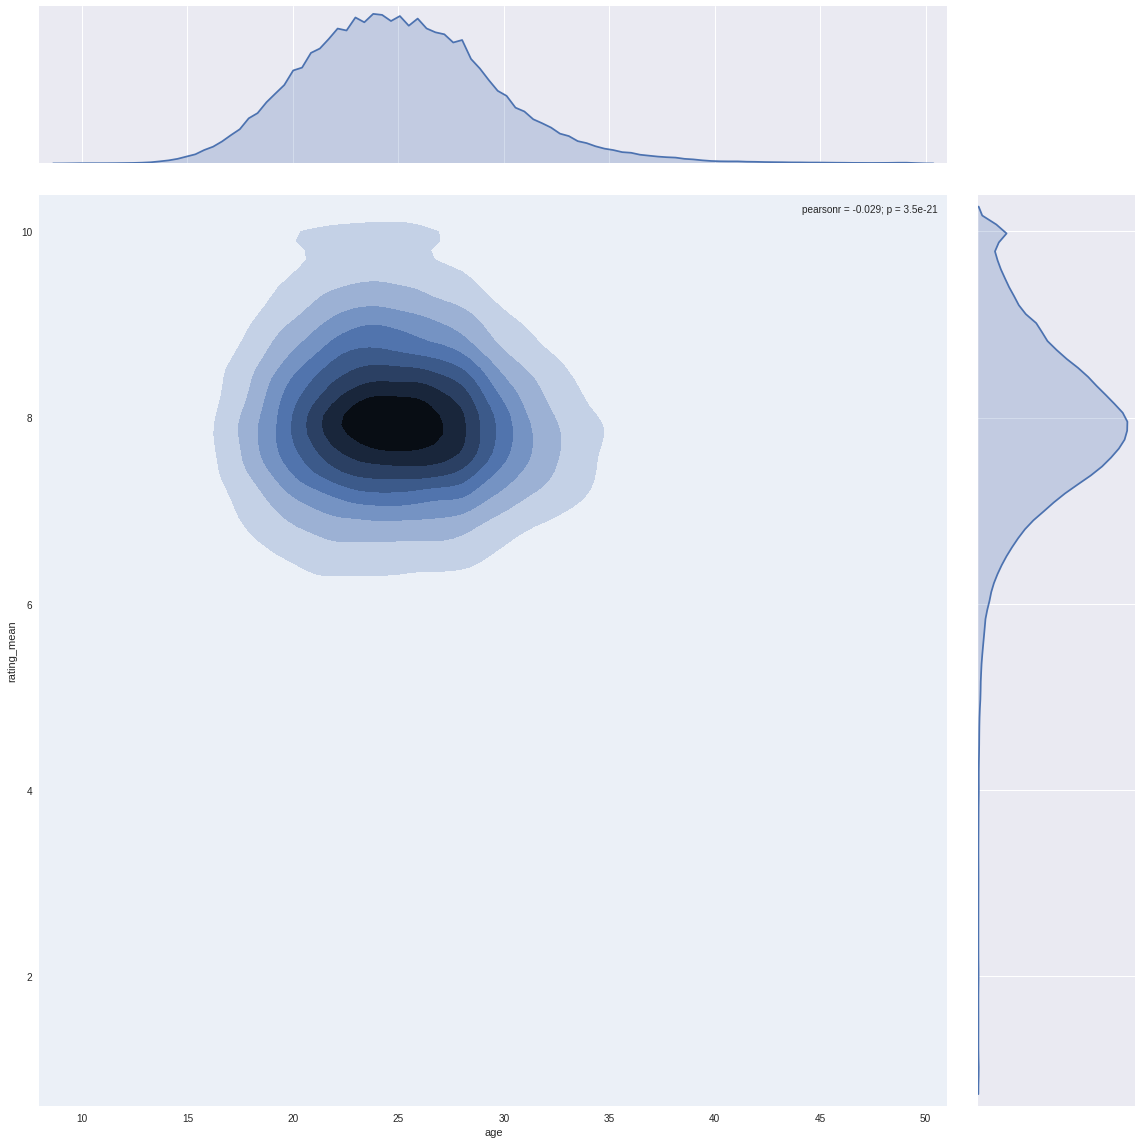

In [46]:
sns.jointplot(x='age', y='rating_mean', data=users, size=16, kind='kde')

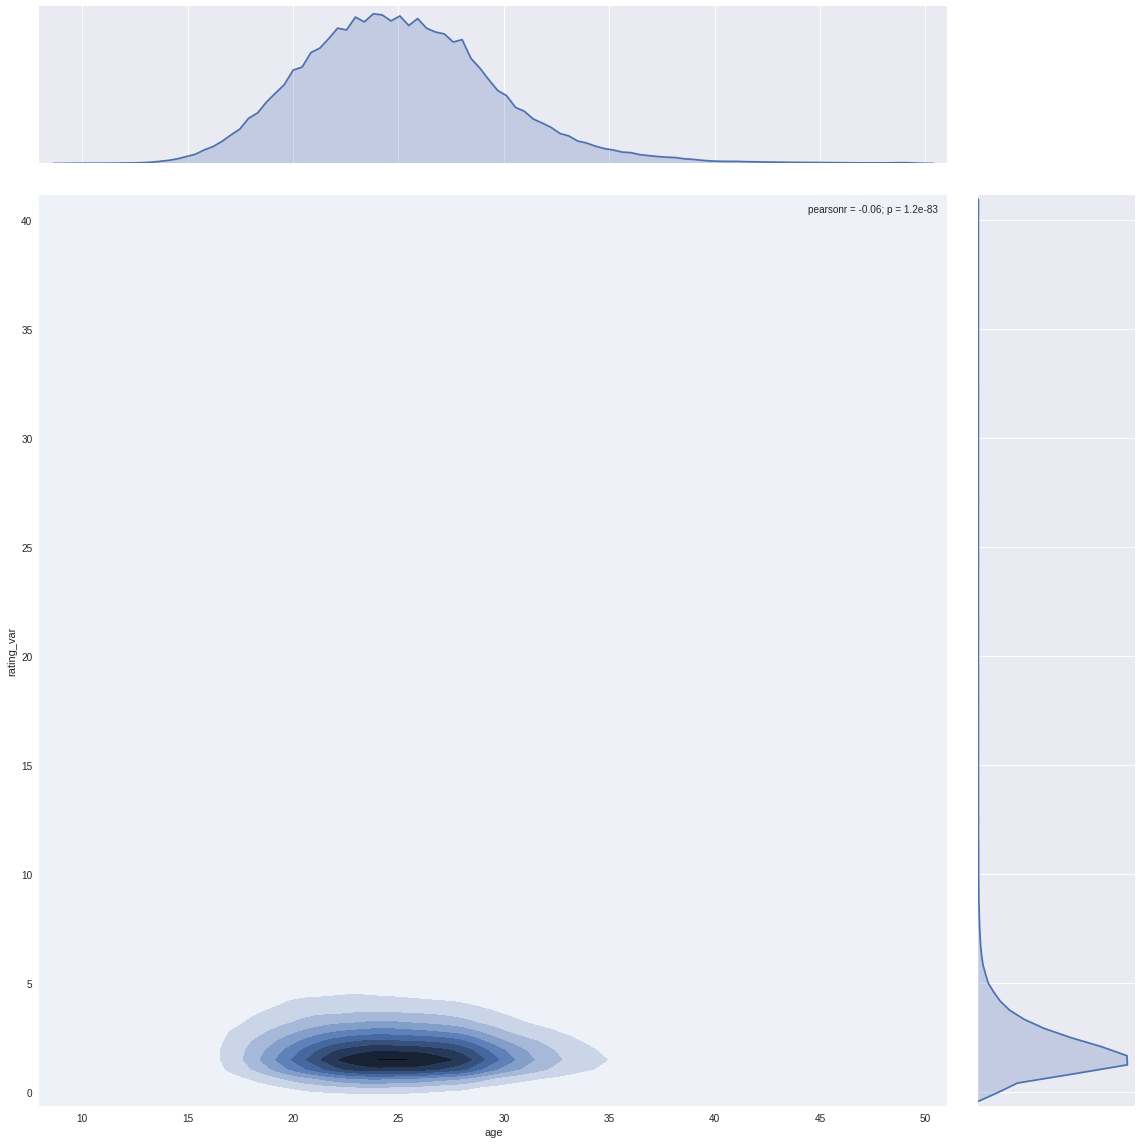

In [47]:
sns.jointplot(x='age', y='rating_var', data=users, size=16, kind='kde')

In [48]:
users['seen_anime'] = animelists.groupby('username')['anime_id'].count()

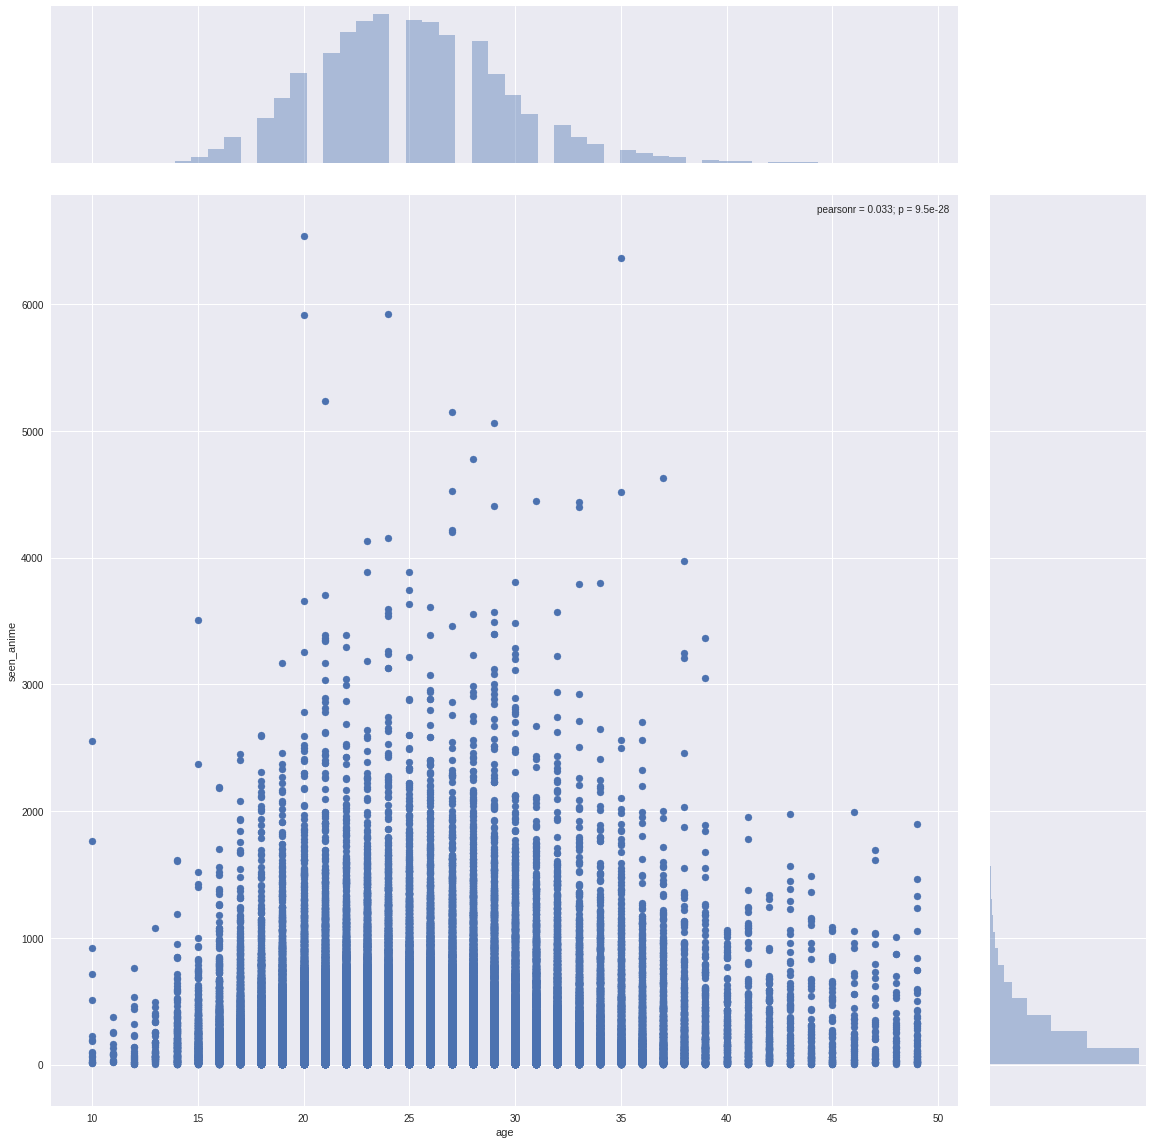

In [49]:
sns.jointplot(x='age', y='seen_anime', data=users, size=16)

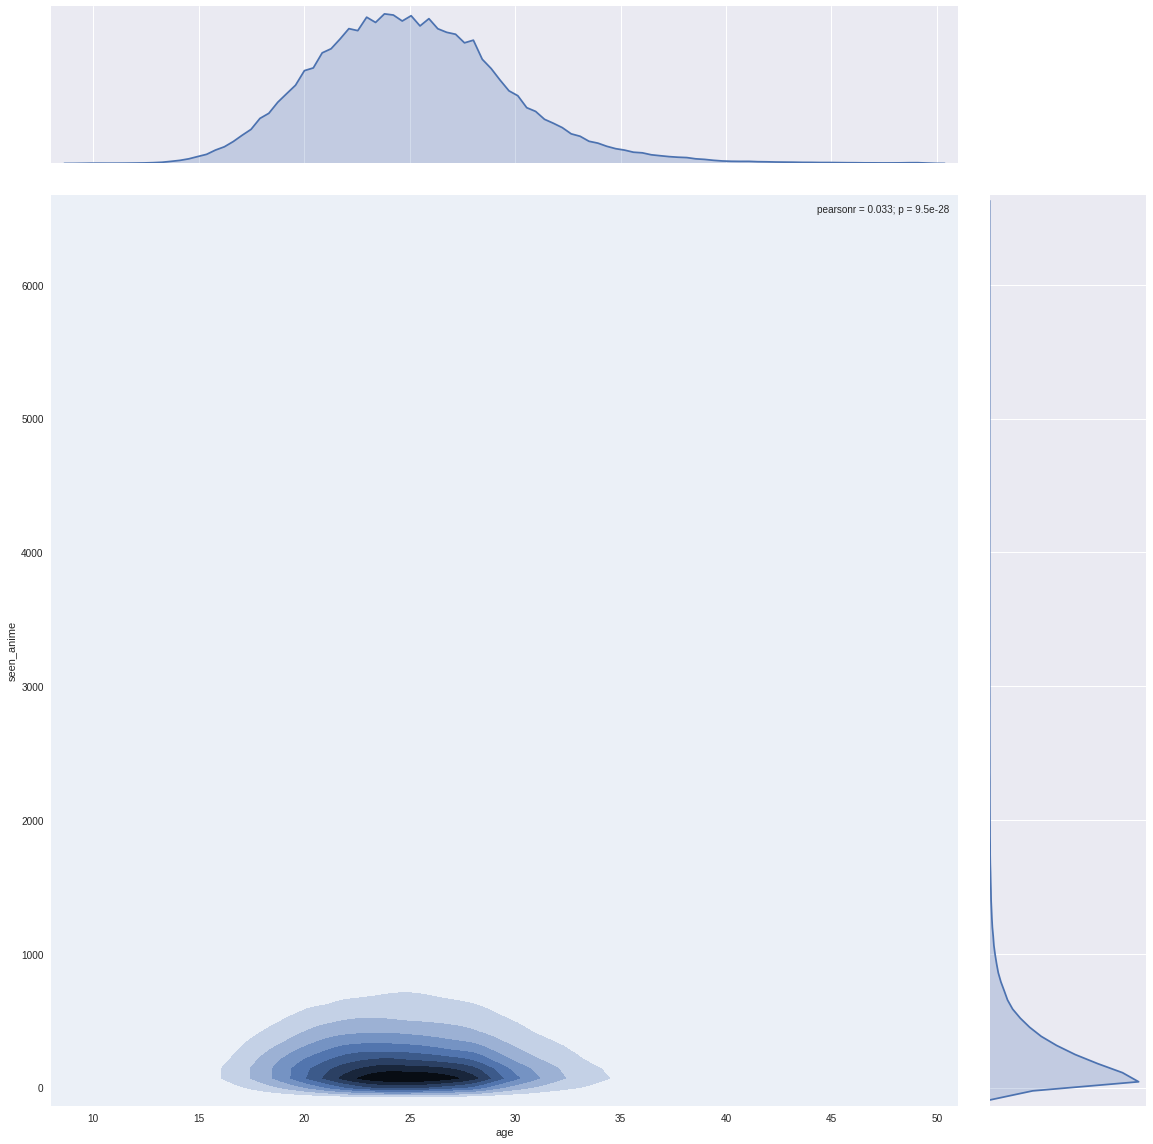

In [50]:
sns.jointplot(x='age', y='seen_anime', data=users, size=16, kind='kde')

In [51]:
users['days_on_mal'] = (users['last_online'] - users['join_date']) / np.timedelta64(1, 'D')

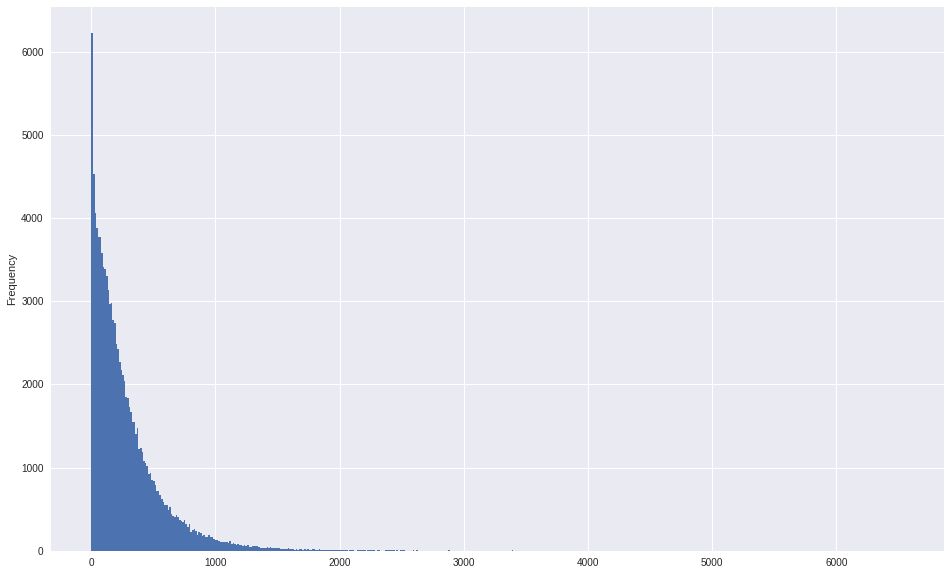

In [52]:
users['seen_anime'].plot(kind='hist', bins=500, figsize=(16, 10))

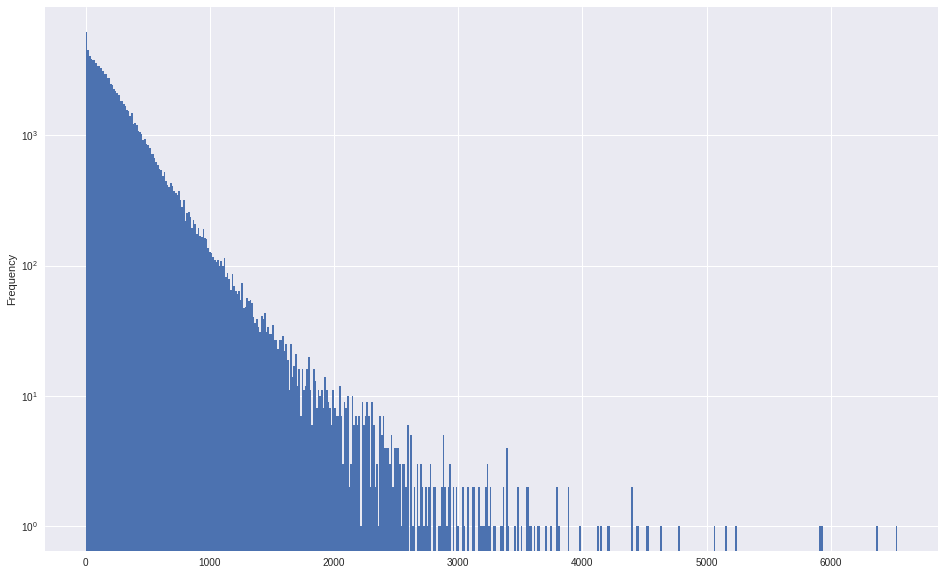

In [53]:
users['seen_anime'].plot(kind='hist', bins=500, figsize=(16, 10), logy=True)

In [54]:
users[users['days_on_mal'] > 4500][['user_id', 'join_date', 'last_online', 'days_on_mal']]

user_id  join_date         last_online  days_on_mal
username                                                        
Xinil              1 2004-11-05 2018-05-14 18:02:55  4938.752025
Achtor            82 2005-04-29 2018-05-13 11:11:00  4762.465972
vondur            20 2005-01-05 2018-02-28 17:27:29  4802.727419
Crystal            4 2004-11-13 2018-05-14 13:04:48  4930.545000
Baman             36 2005-02-05 2018-05-20 04:57:26  4852.206551
Arinohyoshi      208 2005-01-30 2017-10-09 18:32:43  4635.772720

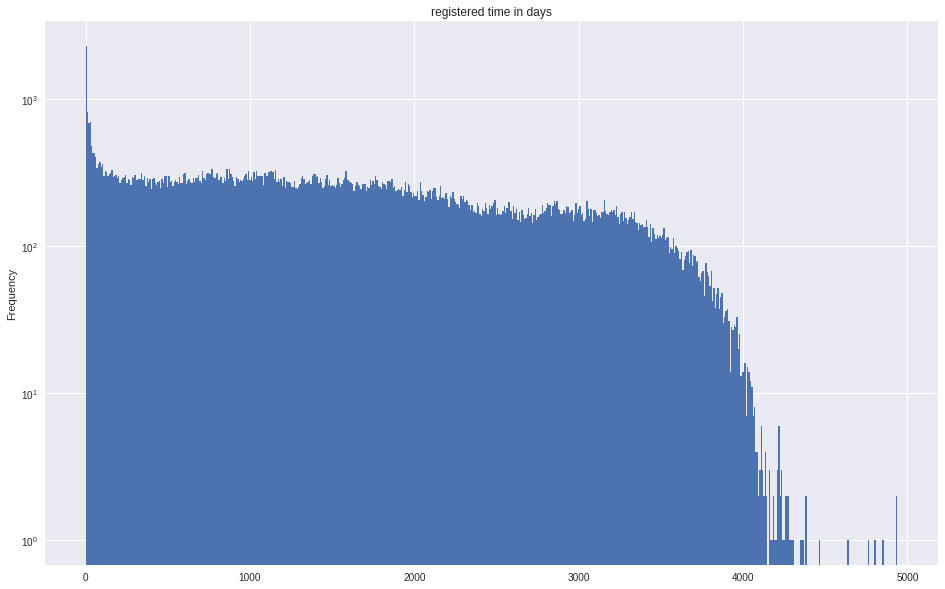

In [55]:
users['days_on_mal'].plot(kind='hist', logy=True, bins=600, figsize=(16, 10), title='registered time in days')

In [56]:
users[users['seen_anime'] > 5000]['seen_anime'].value_counts()

6536.0    1
6367.0    1
5234.0    1
5923.0    1
5062.0    1
5151.0    1
5912.0    1
Name: seen_anime, dtype: int64

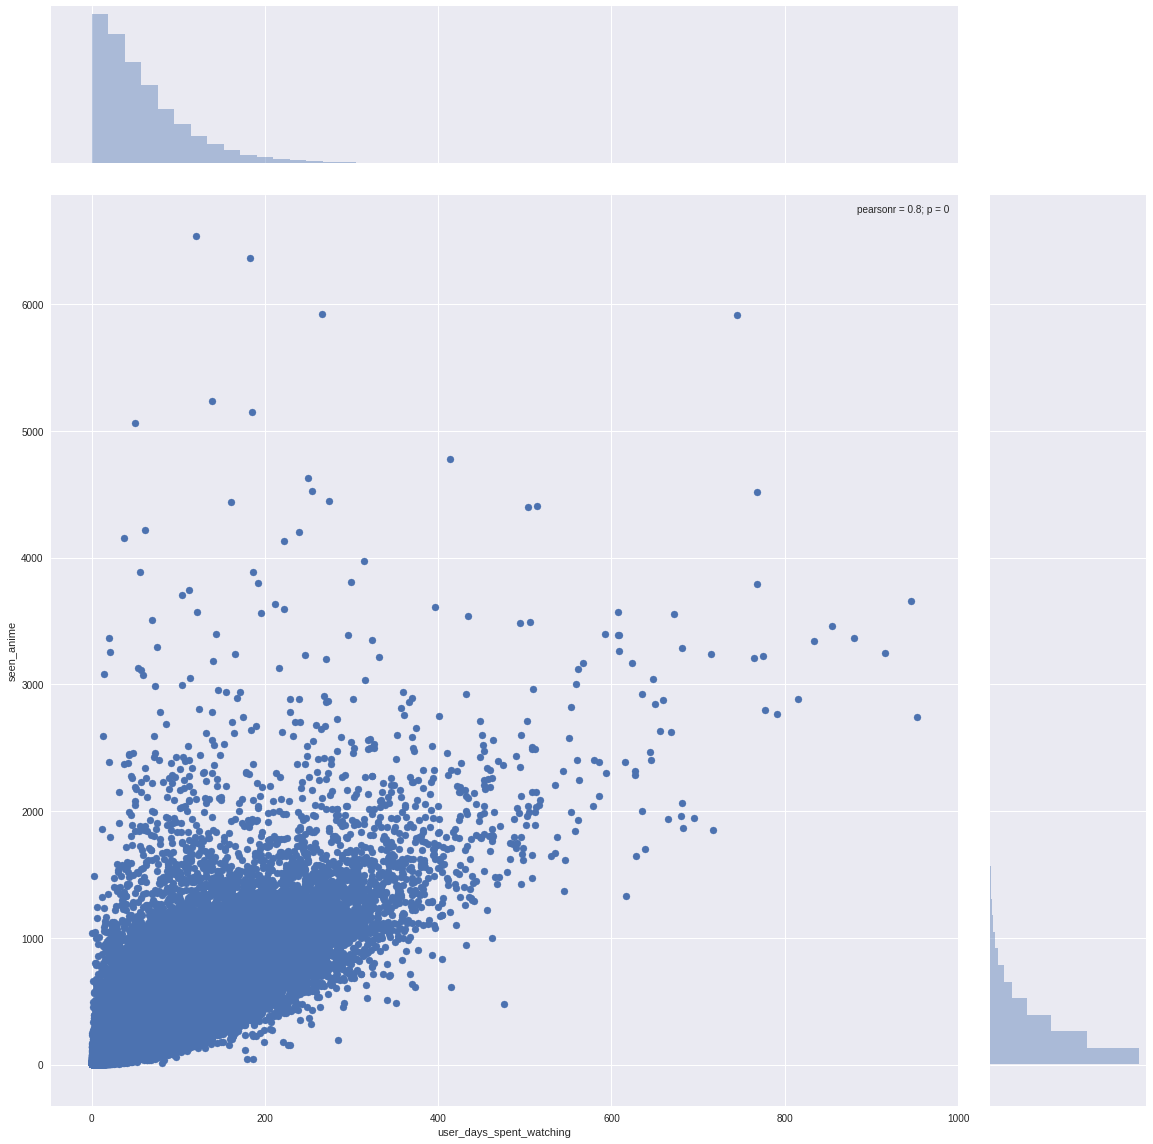

In [57]:
sns.jointplot(x='user_days_spent_watching', y='seen_anime', data=users, size=16)

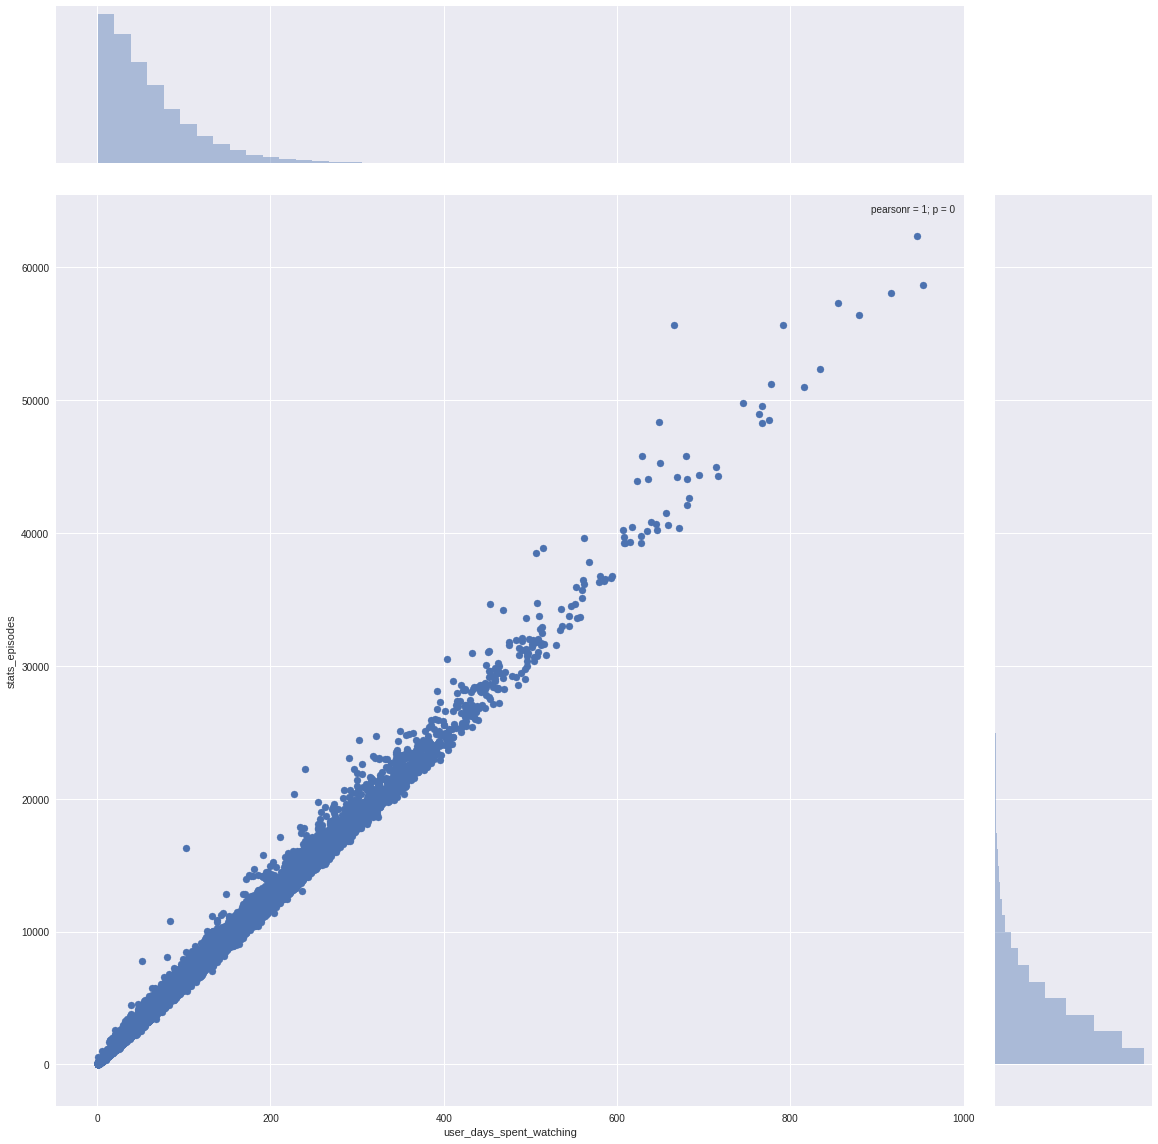

In [58]:
sns.jointplot(x='user_days_spent_watching', y='stats_episodes', data=users, size=16)

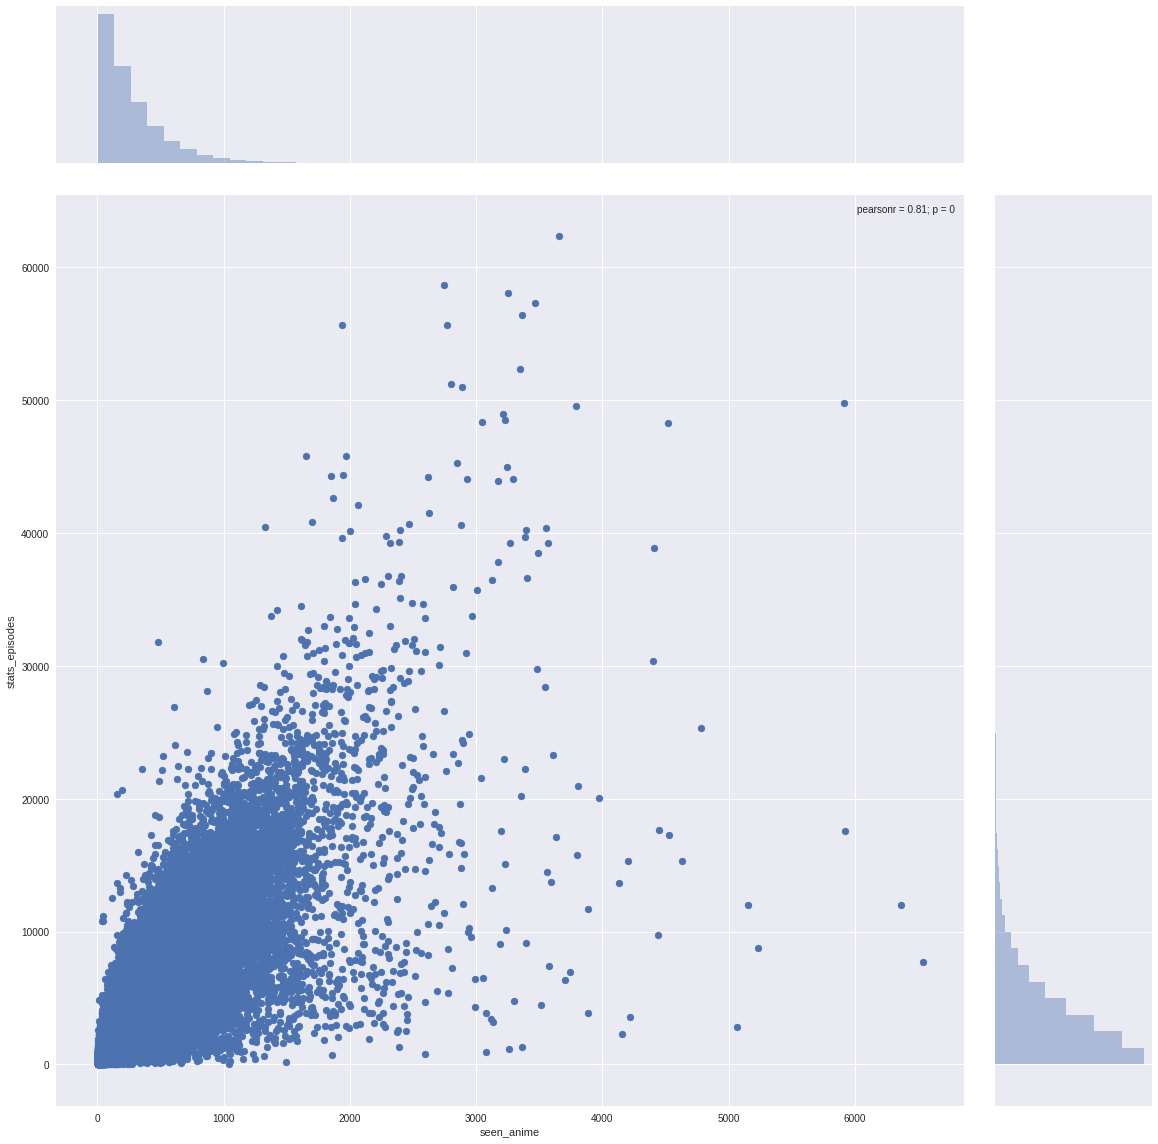

In [59]:
sns.jointplot(x='seen_anime', y='stats_episodes', data=users, size=16)

In [60]:
users.columns

Index(['user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes',
       'age', 'rating_mean', 'rating_var', 'seen_anime', 'days_on_mal'],
      dtype='object')

In [61]:
users['rating_mean'].isnull().sum()

2309

In [62]:
users['rating_mean'].fillna(0, inplace=True)
users['rating_var'].fillna(0, inplace=True)

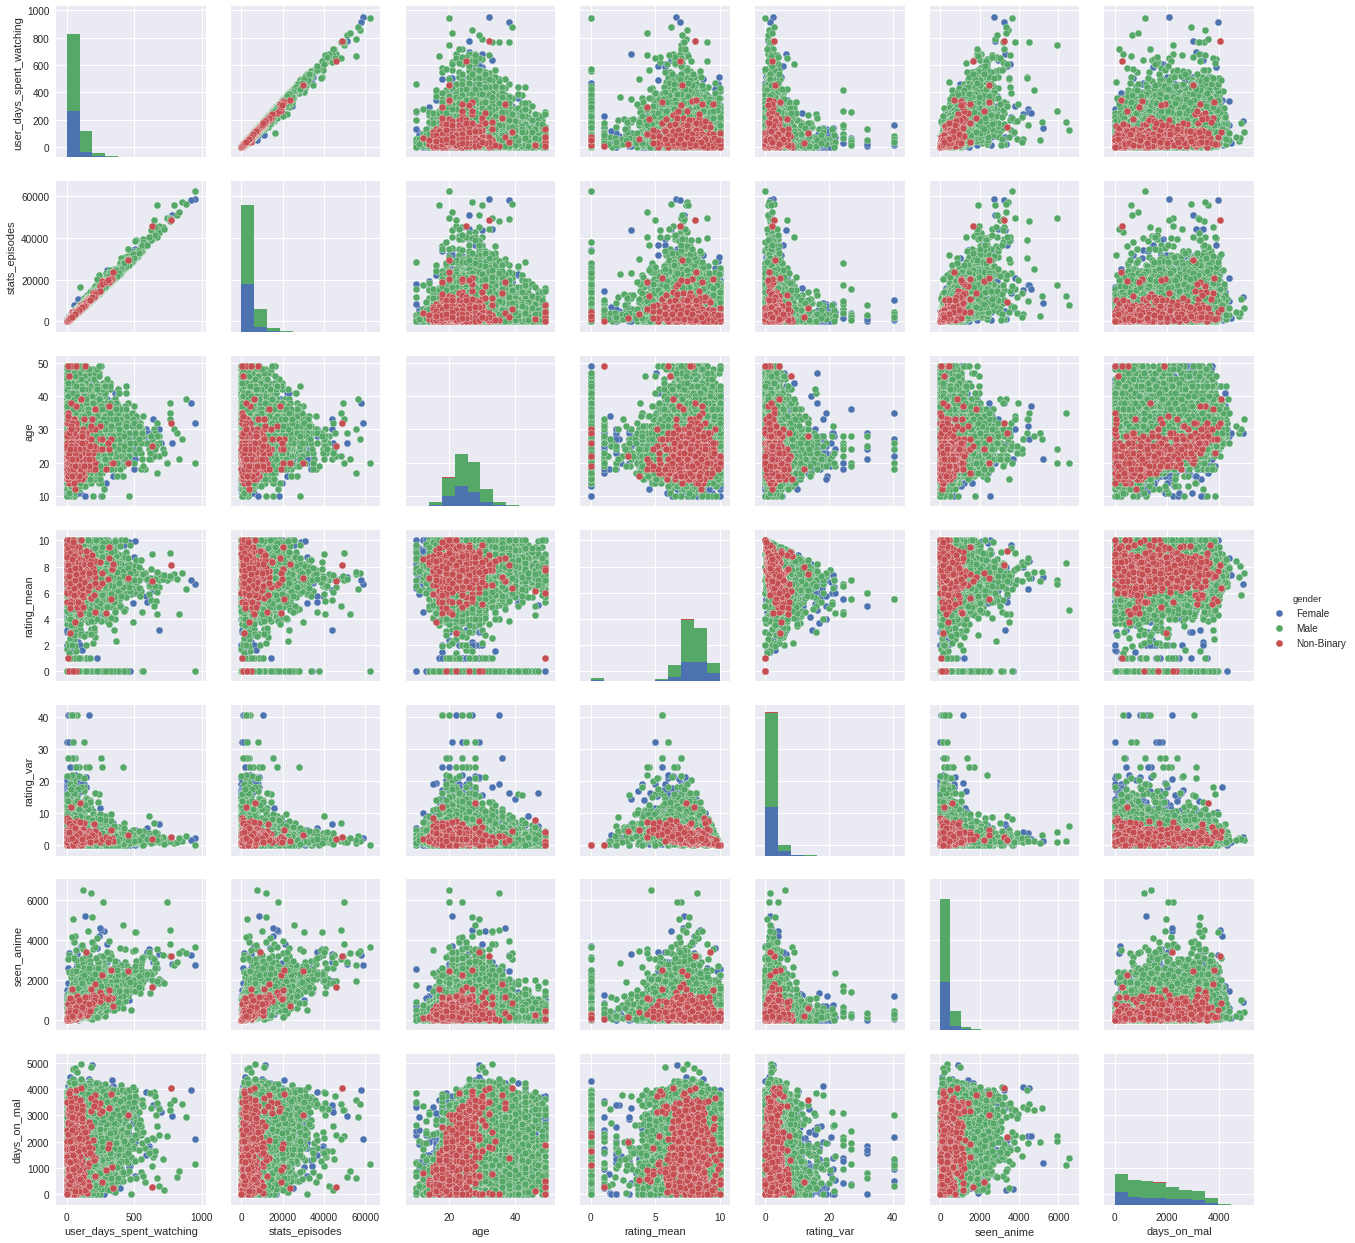

In [63]:
sns.pairplot(users[['user_days_spent_watching',
       'gender', 'birth_date', 'join_date',
       'last_online', 'stats_episodes',
       'age', 'rating_mean', 'rating_var', 'seen_anime',
       'days_on_mal']], hue='gender')

### inspecting anime age ratings

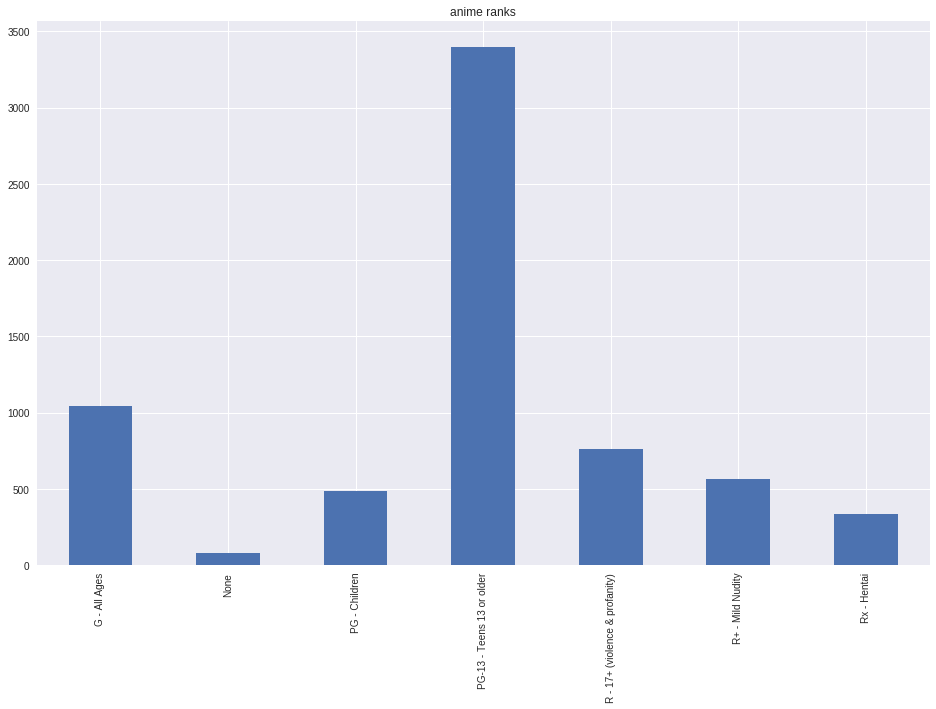

In [64]:
animes['rating'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime ranks')

In [65]:
(animes['rating'].value_counts() / animes.shape[0]).sort_index().plot.bar(figsize=(16, 10), title='anime ranks')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

### inspecting anime sources

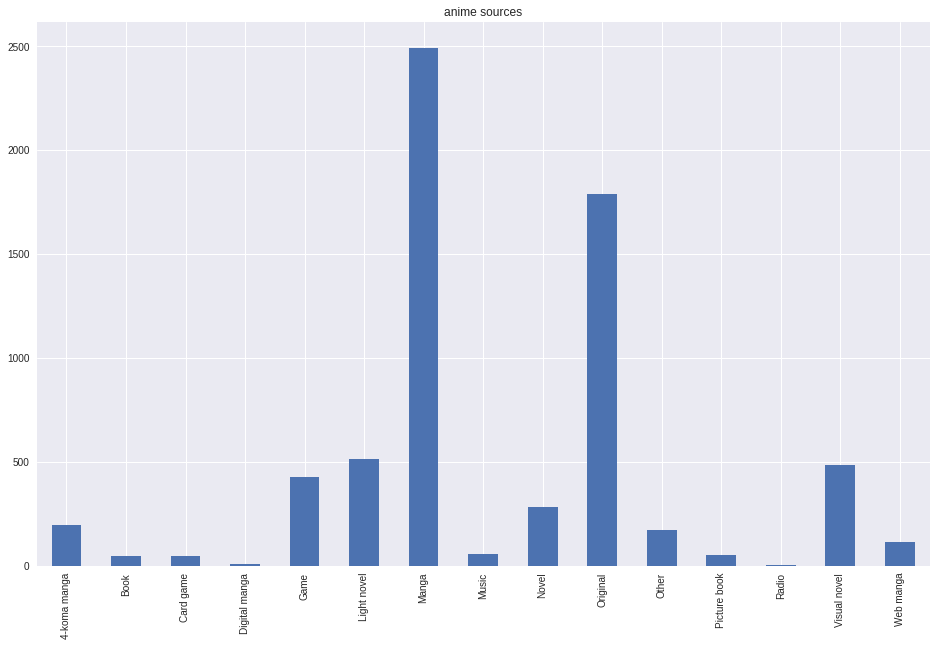

In [66]:
animes['source'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime sources')

In [67]:
year_source = pd.crosstab(animes['aired_from'].dt.year, animes['source'])
year_source.index = year_source.index.astype(np.int)
# keeping only interesting sources
interesting_sources = ['Game', 'Light novel', 'Manga', 'Original', 'Visual novel']
other_sources = list(set(year_source.columns) - set(interesting_sources))
year_source['other'] = year_source[other_sources].sum(axis=1)
year_source = year_source.drop(other_sources, axis=1)
colors = plt.cm.Set1(np.linspace(0, 1, year_source.shape[1]))

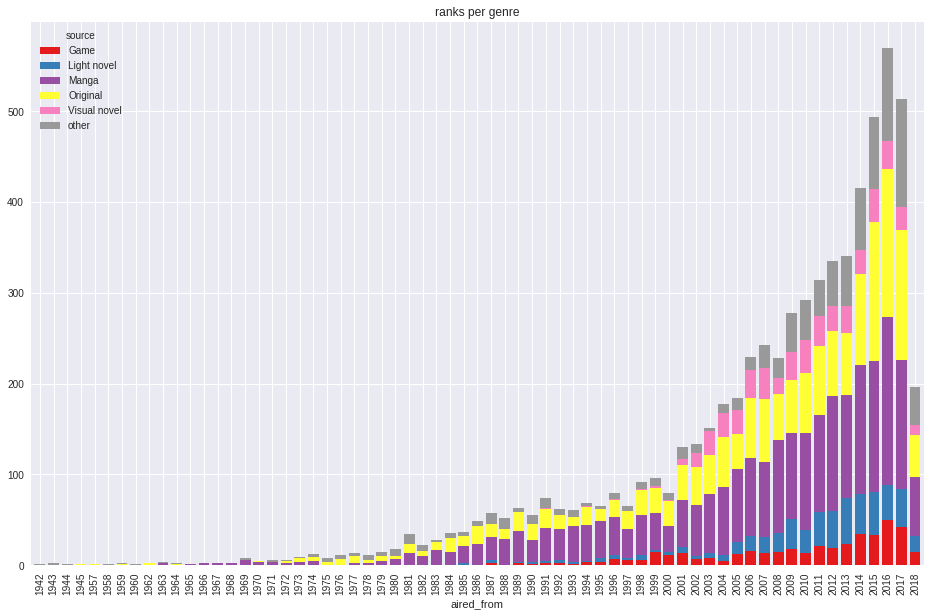

In [68]:
year_source.plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)

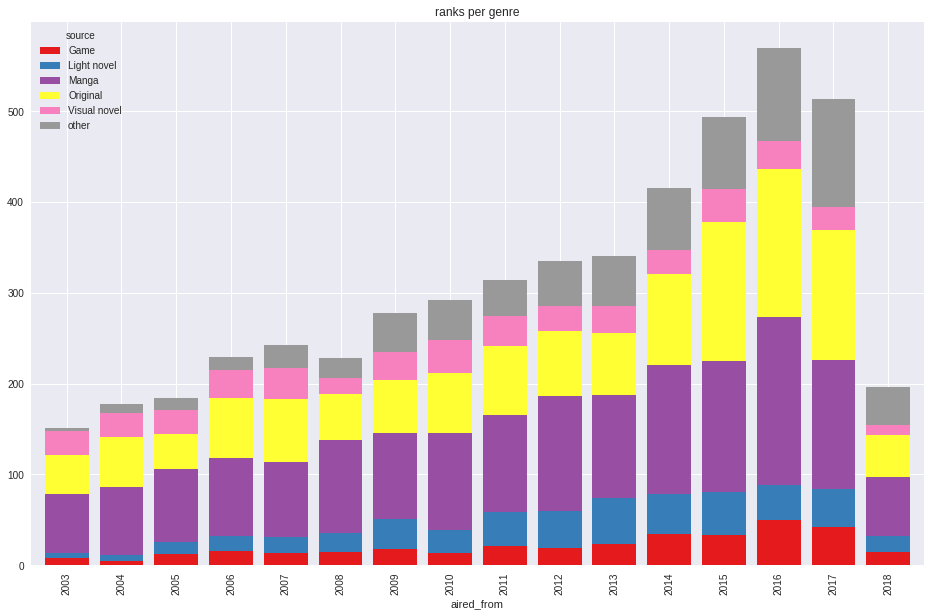

In [69]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)

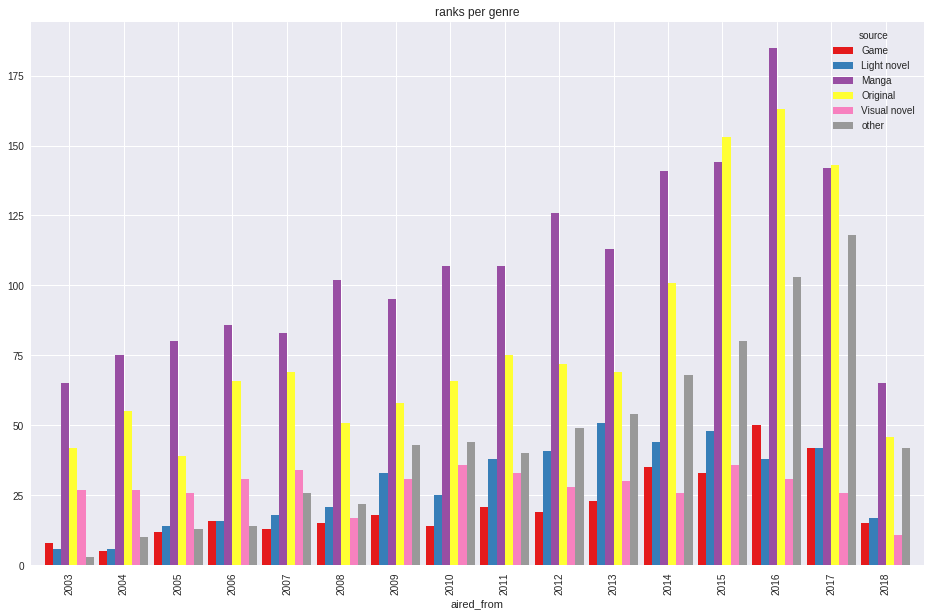

In [70]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=False, figsize=(16, 10), title='ranks per genre', color=colors, width=0.9)

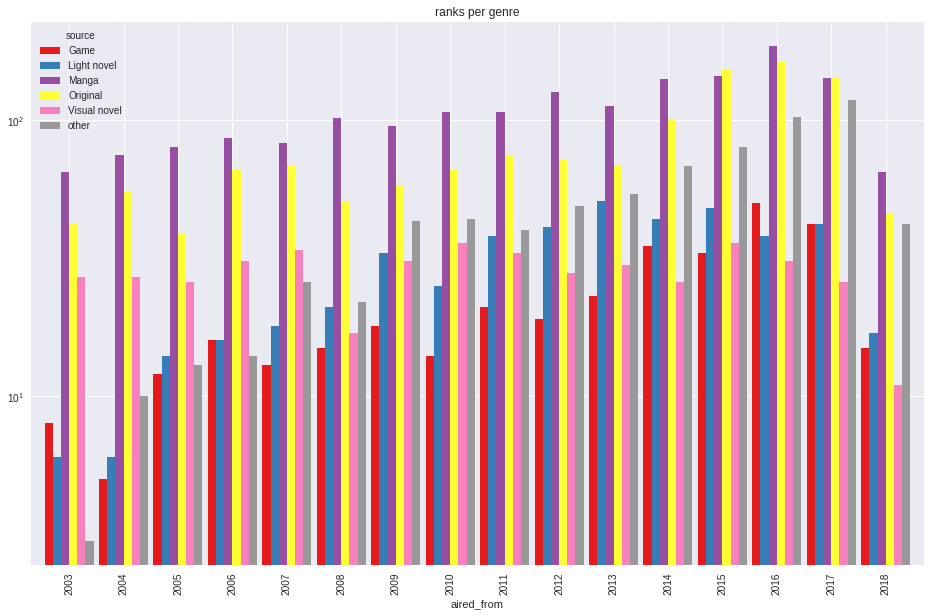

In [71]:
year_source[year_source.index >= 2003].plot(kind='bar', stacked=False, figsize=(16, 10), title='ranks per genre', color=colors, width=0.9, logy=True)

In [72]:
year_source.div(year_source.sum(axis=1), axis=0)[year_source.index >= 2003].plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [73]:
animes[animes['source'] == 'Unknown'].sort_values(by='popularity')[['title', 'source', 'studios', 'genres', 'popularity']]

Empty DataFrame
Columns: [title, source, studios, genres, popularity]
Index: []

In [74]:
animes[(animes['source'] == 'Unknown') & (animes['studios'].isnull())].shape

(0, 33)

In [77]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing     ...      \
anime_id                                        ...       
11013           12  Finished Airing   False     ...       
2104            26  Finished Airing   False     ...       
5262            51  Finished Airing   False     ...       
721             38  Finished Airing   False     ...       
12365           25  Finished Airing   False     ...       

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsuko Okazaki']   
12365     ['#1: "Moshimo no Hanashi (もしもの話)" by nano.RIP...   

                                               ending_theme  duration_min  \
anime_id                                                                    
11013     ['

In [78]:
animes_genres.head()

title              title_english title_japanese  \
anime_id                                                                 
11013    0     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         1     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         2     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
         3     Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104     0  Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   

                  title_synonyms  \
anime_id                           
11013    0       Youko x Boku SS   
         1       Youko x Boku SS   
         2       Youko x Boku SS   
         3       Youko x Boku SS   
2104     0  The Inland Sea Bride   

                                                    image_url type source  \
anime_id                                                                    
11013    0  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         1  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         2  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
         3  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   
2104     0  https://myanimelist.cdn-dena.com/images/anime/...   TV  Manga   

            episodes           status  airing      ...       \
anime_id                                           ...        
11013    0        12  Finished Airing   False      ...        
         1        12  Finished Airing   False      ...        
         2        12  Finished Airing   False      ...        
         3        12  Finished Airing   False      ...        
2104     0        26  Finished Airing   False      ...        

                                                     producer  \
anime_id                                                        
11013    0  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         1  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         2  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
         3  Aniplex, Square Enix, Mainichi Broadcasting Sy...   
2104     0                  TV Tokyo, AIC, Square Enix, Sotsu   

                    licensor           studios  \
anime_id                                         
11013    0  Sentai Filmworks  David Production   
         1  Sentai Filmworks  David Production   
         2  Sentai Filmworks  David Production   
         3  Sentai Filmworks  David Production   
2104     0        Funimation             Gonzo   

                                              genres  \
anime_id                                               
11013    0    Comedy, Supernatural, Romance, Shounen   
         1    Comedy, Supernatural, Romance, Shounen   
         2    Comedy, Supernatural, Romance, Shounen   
         3    Comedy, Supernatural, Romance, Shounen   
2104     0  Comedy, Parody, Romance, School, Shounen   

                                 opening_theme  \
anime_id                                         
11013    0               ['"Nirvana" by MUCC']   
         1               ['"Nirvana" by MUCC']   
         2               ['"Nirvana" by MUCC']   
         3               ['"Nirvana" by MUCC']   
2104     0  ['"Romantic summer" by SUN&LUNAR']   

                                                 ending_theme  duration_min  \
anime_id                                                                      
11013    0  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
         1  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
         2  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
         3  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...          24.0   
2104     0  ['#1: "Ashita e no Hikari (明日への光)" by Asuka Hi...          24.0   

            aired_from_year  aired_from         genre  
anime_id                                               
11013    0           2012.0  2012-01-13        Comed

In [79]:
animes_genres.shape

(23750, 34)

In [80]:
animes_genres = animes_genres[animes_genres['genre'] != '']

In [81]:
rank_count = animes_genres['rating'].unique().size

In [82]:
colors = plt.cm.tab10(np.linspace(0, 1, rank_count))
genre_ranks = pd.crosstab(animes_genres['genre'], animes_genres['rating'])
genre_ranks.plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors)

In [83]:
rank_genres = pd.crosstab(animes_genres['rating'], animes_genres['genre'])
rank_genres.plot(kind='bar', stacked=True, figsize=(16, 10), title='genres per rank')

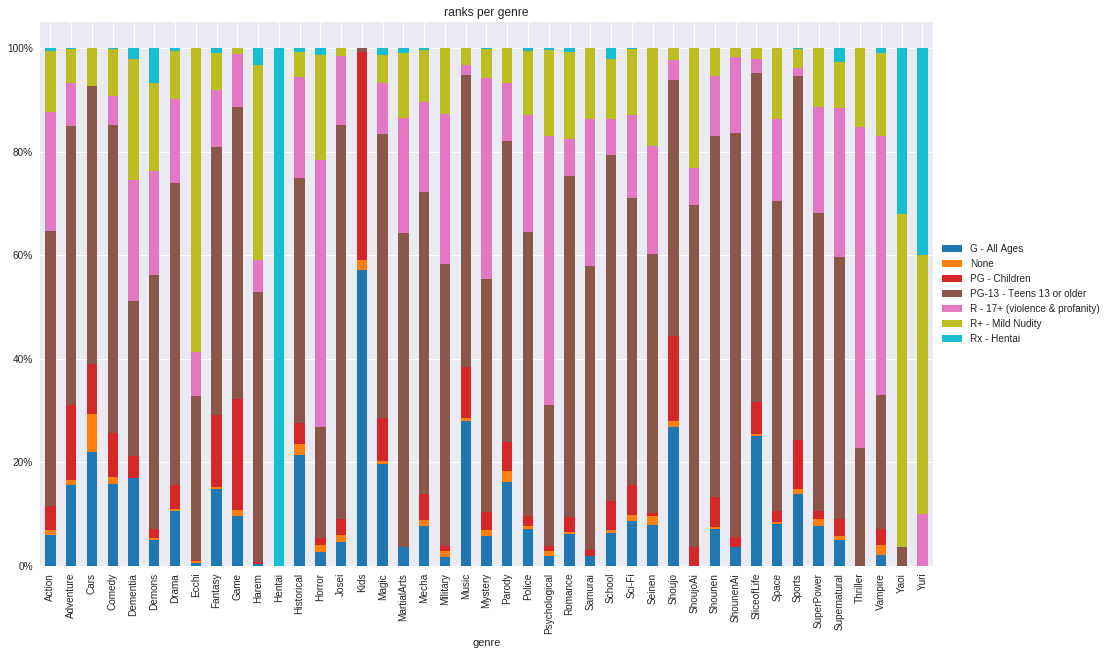

In [84]:
colors = plt.cm.tab10(np.linspace(0, 1, rank_count))
genre_ranks.div(genre_ranks.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## inspecting studios and genres

In [85]:
print('unique studios combinations:')
animes['studios'].unique().size

unique studios combinations:


711

In [86]:
# now comes some data cleaning, getting rid of commas in studio names for easier manipulation
animes.loc[animes['studios'] == 'Yamamura Animation, Inc.', 'studios'] = 'Yamamura Animation'
# here, in animes_genres, is every anime duplicated, once per each genre it contains
animes['studios'].fillna('', inplace=True)
studios_arr = animes['studios'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='studio')
studios_arr.index.levels[0].name = 'anime_id'
animes_studios = pd.merge(animes, studios_arr, how='inner', left_index=True, right_index=True)
animes_studios = animes_studios[animes_studios['studio'] != '']

In [87]:
print('unique studios:')
animes_studios['studio'].unique().size

unique studios:


474

In [88]:
animes_studios['studio'].value_counts().sort_values(ascending=False)

ToeiAnimation           419
Sunrise                 291
Madhouse                277
J.C.Staff               251
StudioPierrot           248
StudioDeen              223
ProductionI.G           222
A-1Pictures             174
TMSEntertainment        172
OLM                     151
Gonzo                   121
Xebec                   118
Shaft                   116
NipponAnimation         111
Bones                   110
KyotoAnimation          104
AIC                     103
DLE                      94
TatsunokoProduction      92
Brain&#039;sBase         85
Satelight                80
Gainax                   80
SilverLink.              75
Shin-EiAnimation         69
Arms                     66
feel.                    61
Zexcs                    61
ProductionReed           61
DogaKobo                 60
ufotable                 53
                       ... 
KinoProduction            1
MilkyAnimationLabel       1
Odolttogi                 1
Cygames                   1
PurpleCowStudioJapan

In [89]:
known_studios = animes_studios['studio'].value_counts().sort_values(ascending=False).index[0:35]
known_studios

Index(['ToeiAnimation', 'Sunrise', 'Madhouse', 'J.C.Staff', 'StudioPierrot',
       'StudioDeen', 'ProductionI.G', 'A-1Pictures', 'TMSEntertainment', 'OLM',
       'Gonzo', 'Xebec', 'Shaft', 'NipponAnimation', 'Bones', 'KyotoAnimation',
       'AIC', 'DLE', 'TatsunokoProduction', 'Brain&#039;sBase', 'Satelight',
       'Gainax', 'SilverLink.', 'Shin-EiAnimation', 'Arms', 'feel.', 'Zexcs',
       'ProductionReed', 'DogaKobo', 'ufotable', 'StudioGhibli', 'Seven',
       'Artland', 'StudioGallop', 'StudioHibari'],
      dtype='object')

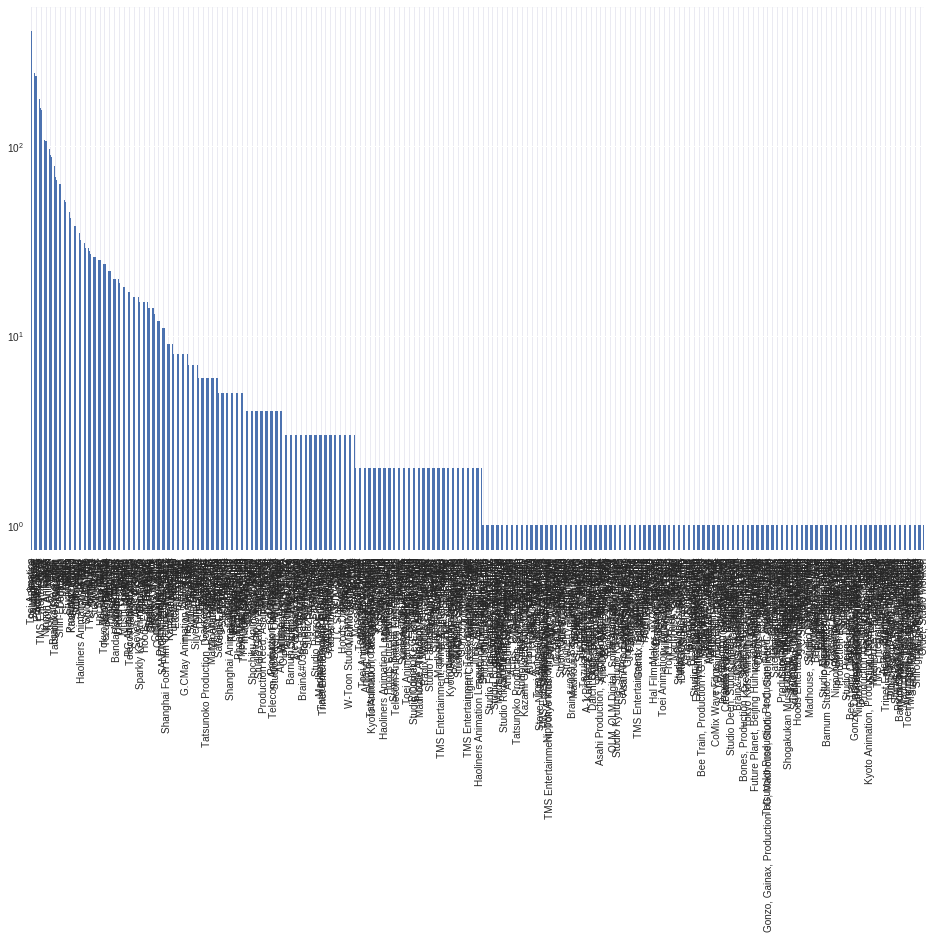

In [90]:
animes['studios'].value_counts().plot(kind='bar', figsize=(16, 10), logy=True)

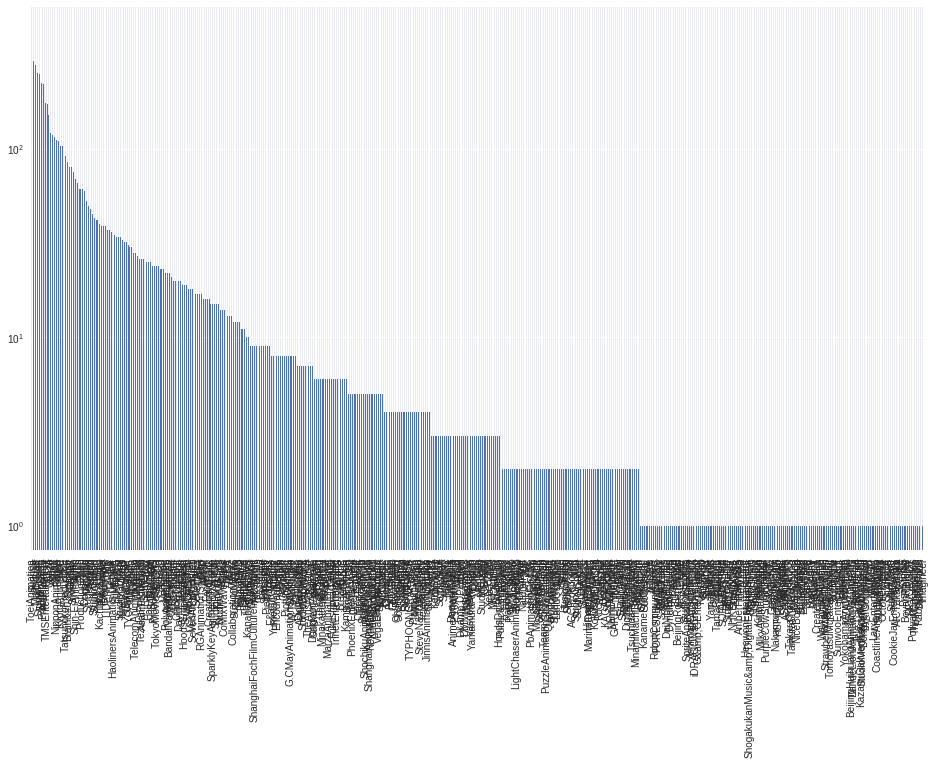

In [91]:
animes_studios['studio'].value_counts().plot(kind='bar', figsize=(16, 10), logy=True)

In [92]:
animes_studios['studio'].value_counts().value_counts().plot(kind='bar', figsize=(16, 10))

In [93]:
studio_counts = animes_studios['studio'].value_counts().sort_values(ascending=False)
# bigger studios are with 10 or more anime
bigger_studios = studio_counts[studio_counts >= 10].index
print('# studios with 10 or more anime')
len(bigger_studios)

# studios with 10 or more anime


116

In [94]:
animes_studios[animes_studios['studio'].isin(bigger_studios)]['studio'].value_counts().plot(kind='bar', figsize=(16, 10))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

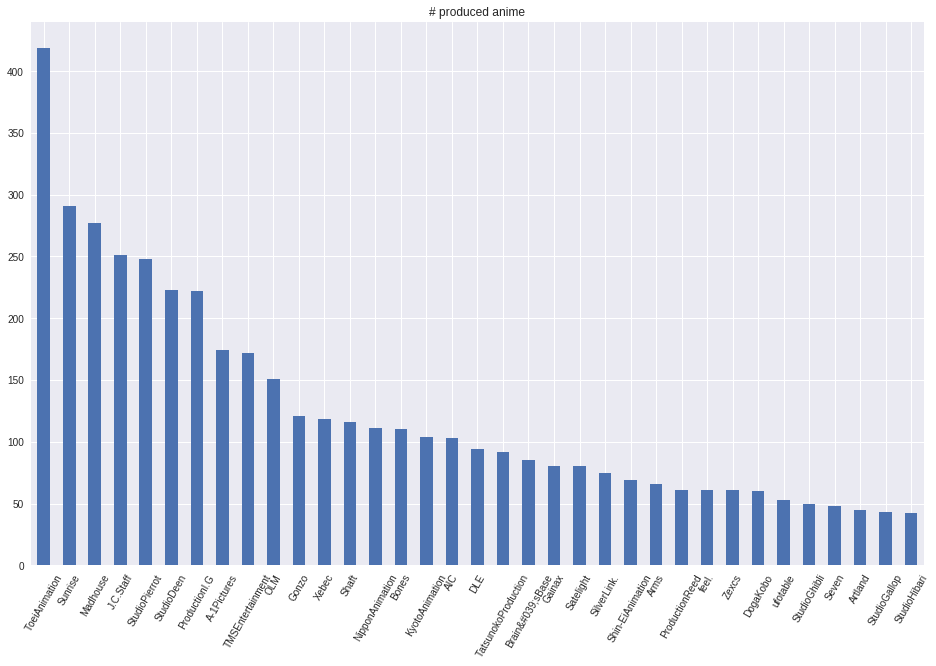

In [95]:
animes_studios[animes_studios['studio'].isin(known_studios)]['studio'].value_counts().plot(kind='bar', figsize=(16, 10), title='# produced anime')
plt.xticks(rotation=60)

In [96]:
animes_studios_genres = pd.merge(animes_studios.reset_index(), genres_arr.reset_index(), how='inner', on='anime_id').drop(['level_1_x', 'level_1_y'], axis=1)
animes_studios_genres = animes_studios_genres[animes_studios_genres['genre'] != '']

In [97]:
studios_genres = pd.crosstab(animes_studios_genres['studio'], animes_studios_genres['genre'])
# only for known studios
studios_genres = studios_genres[studios_genres.index.isin(known_studios)]

In [98]:
studios_genres.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'MartialArts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'ShoujoAi', 'Shounen',
       'ShounenAi', 'SliceofLife', 'Space', 'Sports', 'SuperPower',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object', name='genre')

In [99]:
interesting_genres = ['Action', 'Adventure', 'Comedy', 'Drama',
       'Fantasy', 'Hentai', 
       'Kids', 'Magic', 'Mecha', 'Music',
       'Mystery', 'Romance', 
       'Sci-Fi', 'SliceofLife']

In [100]:
# group rest of genres to "other" value
other_genres = list(set(studios_genres.columns) - set(interesting_genres))
studios_genres['other'] = studios_genres[other_genres].sum(axis=1)
studios_genres.drop(other_genres, inplace=True, axis=1)
studios_genres

genre                Action  Adventure  Comedy  Drama  Fantasy  Hentai  Kids  \
studio                                                                         
A-1Pictures              66         28      85     25       59       0     2   
AIC                      47         30      51     16       16       1     0   
Arms                     29         15      15     10       18      20     1   
Artland                  14         12      16      7       14       0     0   
Bones                    67         30      47     38       28       0     1   
Brain&#039;sBase         19          9      46     18       18       0     0   
DLE                       5          1      73      1        5       0     7   
DogaKobo                 11          2      43      8       12       0     0   
Gainax                   30         12      43     15        5       0     2   
Gonzo                    62         33      48     28       22       0     1   
J.C.Staff                60         38     139     66       53       2     0   
KyotoAnimation           10          2      60     25       23       0     0   
Madhouse                 93         78     107    110       63       0    14   
NipponAnimation          13         56      35     42       17       0    24   
OLM                      55         77      77     31       80       0    89   
ProductionI.G            81         35      87     61       45       0     8   
ProductionReed           24         23      29     14       13       0     1   
Satelight                35         17      26     16       17       0     0   
Seven                     0          1      24      2        2      20     0   
Shaft                    14          8      78     22       11       0     0   
Shin-EiAnimation          5         20      61      4        6       0    12   
SilverLink.              20          2      49      4       18       0     0   
StudioDeen               66         34     129     64       51       0     8   
StudioGallop             18         15      24      9       13       0     2   
StudioGhibli              2         18       6     13       17       0     9   
StudioHibari              9         11      25     16        9       0     3   
StudioPierrot            91         75     137     52       42       0    13   
Sunrise                 161         71      84     84       32       0     4   
TMSEntertainment         52         70     102     29       29       0    22   
TatsunokoProduction      33         31      34     16        5       0     5   
ToeiAnimation           187        170     211     95      192       0    33   
Xebec                    45         18      60     13       23       0     6   
Zexcs                     9          4      28     17       12       0     0   
feel.                     4          0      45      9        8       0     0   
ufotable                 28         10      17      7       20       0     1   

genre                Magic  Mecha  Music  Mystery  Romance  Sci-Fi  \
studio                                                               
A-1Pictures             22      5     26       11       33      28   
AIC                     14     24      2        4       34      50   
Arms                     2      0      0        2       10       5   
Artland                  4      5      3       10       12      12   
Bones                    6     19      7       23       20      39   
Brain&#039;sBase         2      9      2        6       25       7   
DLE                      0      1      6        2        0       3   
DogaKobo                 0      1      1        3       13       3   
Gainax                   8     22      7        4       12      34   
Gonzo                    7     32      1        7       16      56   
J.C.Staff               34     11      6       24       79      37   
KyotoAnimation          10      3     14        5       20       4   
Madhouse                24      9     11       36       58 

In [101]:
colors = plt.cm.tab20(np.linspace(0, 1, studios_genres.shape[1]))
studios_genres.plot.bar(stacked=True, figsize=(16, 10), title='Genres per studio', color=colors)
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

In [102]:
studios_genres.div(studios_genres.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(16, 10), title='Genres per studio', color=colors)
plt.xticks(rotation=60)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

In [103]:
studios_genres.sum(axis=0)

genre
Action         1465
Adventure      1056
Comedy         2141
Drama           987
Fantasy         998
Hentai           43
Kids            268
Magic           414
Mecha           466
Music           207
Mystery         352
Romance         828
Sci-Fi         1013
SliceofLife     593
other          5994
dtype: int64

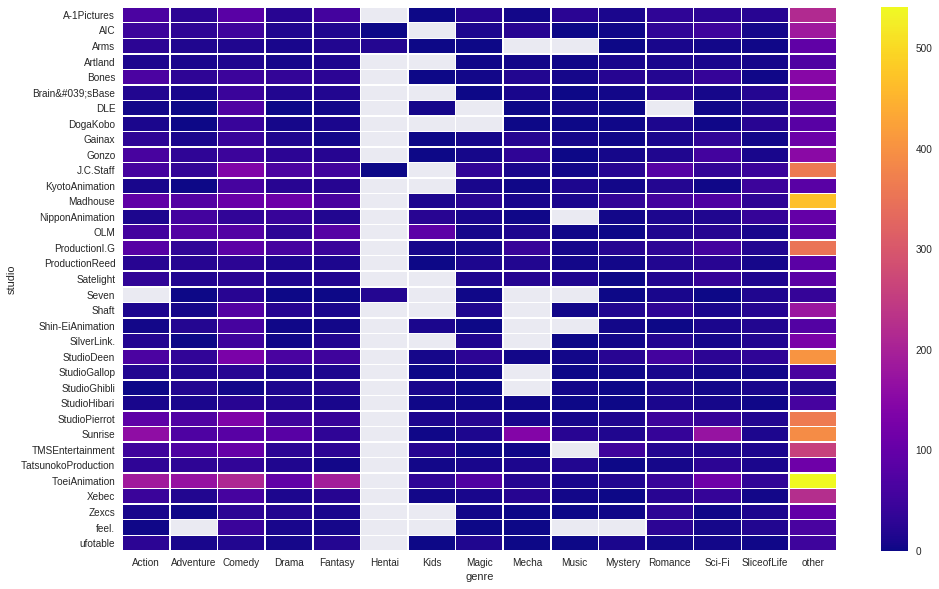

In [104]:
# showing pairwise heatmap from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
colors = plt.cm.plasma(np.linspace(0, 1, studios_genres.max().max()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 0, sep=20, as_cmap=True)

mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True

sns.heatmap(studios_genres, mask=mask, linewidths=.5, cmap=plt.cm.plasma)


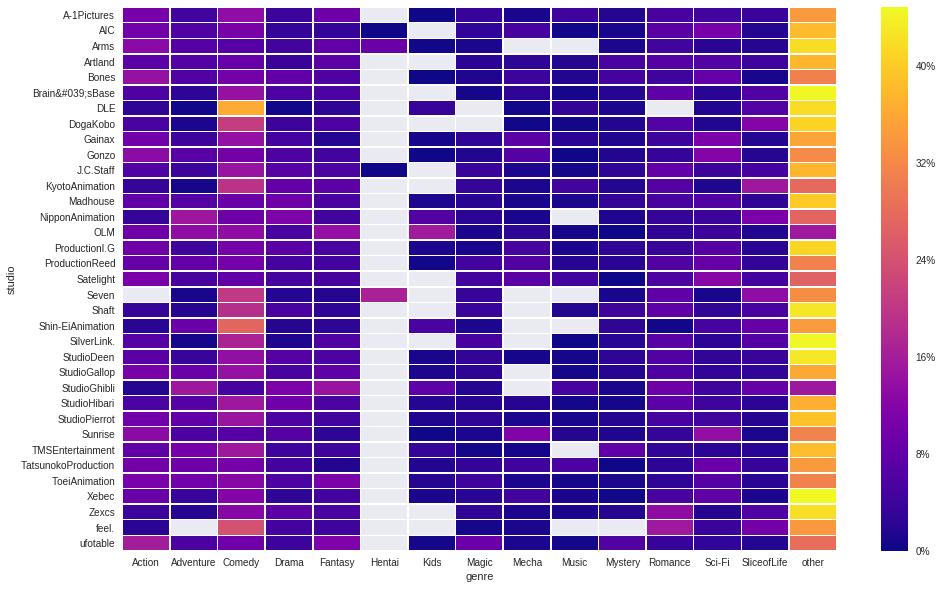

In [105]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.plasma, cbar_kws={'format': '%.0f%%'})


In [106]:
# basically the same thing as above, but for more genres, since heatmap can handle it in this layout
studios_genres = pd.crosstab(animes_studios_genres['studio'], animes_studios_genres['genre'])
studios_genres = studios_genres[studios_genres.index.isin(known_studios)]
interesting_genres = ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'MartialArts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'ShoujoAi', 'Shounen',
       'ShounenAi', 'SliceofLife', 'Space', 'Sports', 'SuperPower',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']

other_genres = list(set(studios_genres.columns) - set(interesting_genres))
# no other genres, so I don't add this column
#studios_genres['other'] = studios_genres[other_genres].sum(axis=1)
studios_genres.drop(other_genres, inplace=True, axis=1)

In [107]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.plasma, cbar_kws={'format': '%.0f%%'})


In [108]:
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})

In [109]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


In [110]:
f, ax = plt.subplots(figsize=(16, 10))
data = studios_genres.div(studios_genres.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(studios_genres, dtype=np.bool)
mask[studios_genres == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

### calculating embeddings to show topology of studio space

In [111]:
def dists_to_csv(nodes_name, edges_name, nodes, dists):
    pairs = np.array(list(combinations(studios_genres.index, 2)))
    
    nodes = pd.DataFrame({'id': studios_genres.index, 'label': studios_genres.index})
    edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': dists})
    edges['type'] = 'undirected'
    
    nodes.to_csv(nodes_name, index=False, sep=',', encoding='utf-8')
    edges.to_csv(edges_name, index=False, sep=',', encoding='utf-8')
    
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'euclidean')
dists_to_csv('studios_nodes.csv', 'studios_edges_eucledian.csv', studios_genres.index, dists)

In [112]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'cityblock')
dists_to_csv('studios_nodes.csv', 'studios_edges_cityblock.csv', studios_genres.index, dists)

In [113]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'correlation')
dists_to_csv('studios_nodes.csv', 'studios_edges_correlation.csv', studios_genres.index, 1 / dists)

In [114]:
dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), 'cosine')
dists_to_csv('studios_nodes.csv', 'studios_edges_cosine.csv', studios_genres.index, 1 / dists)

In [115]:
# using Jensen Shannon diverge, which is symeterized version of KL divergence
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def js_metric(p, q):
    # with square root it will satisfy triangle inequality
    return np.sqrt(js(p, q))

dists = pdist(studios_genres.div(studios_genres.sum(axis=1), axis=0), lambda x, y: js_metric(x, y))
dists_to_csv('studios_nodes.csv', 'studios_edges_js.csv', studios_genres.index, dists)

In [116]:
%matplotlib inline

# using manifold embedding to represent studios in 2D: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html
# using https://github.com/Phlya/adjustText to adjust text labels so they don't overlap
embedder = manifold.MDS(2, max_iter=1000, n_init=5)
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))
# need to agregate animes_studios because it does not contain duplicities because of genres
studio_sizes = animes_studios[animes_studios['studio'].isin(known_studios)]['studio'].value_counts().sort_index()
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=studio_sizes)
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(studios_genres.index)]
adjust_text(texts)


6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


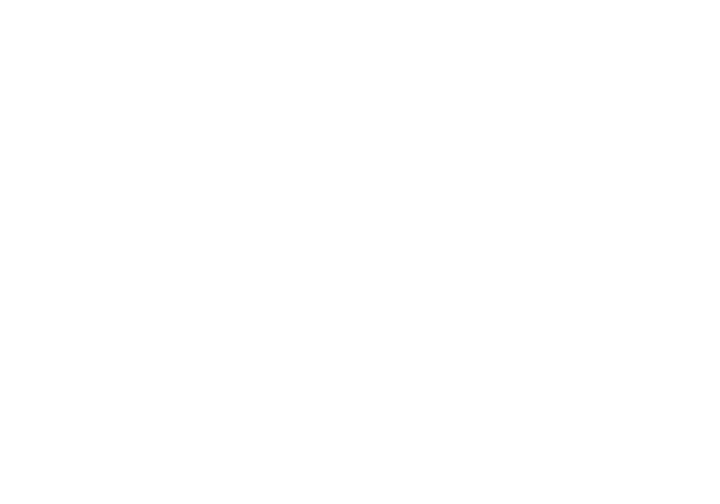

In [117]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=1000, n_init=10)
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))
plt.figure(figsize=(10, 7))

ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=studio_sizes)
plt.title("studios by genres produced in 3D")
for i, txt in enumerate(studios_genres.index):
    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

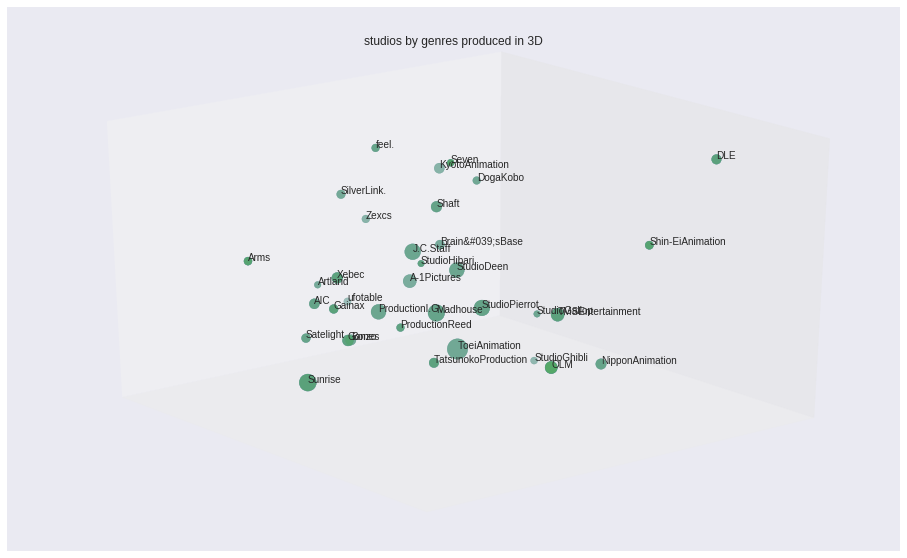

In [118]:
%matplotlib inline

def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("studios by genres produced in 3D")
points_3d_to_gif(embeddings, studios_genres.index, 'studios-genres-MDS', ax, studio_sizes)

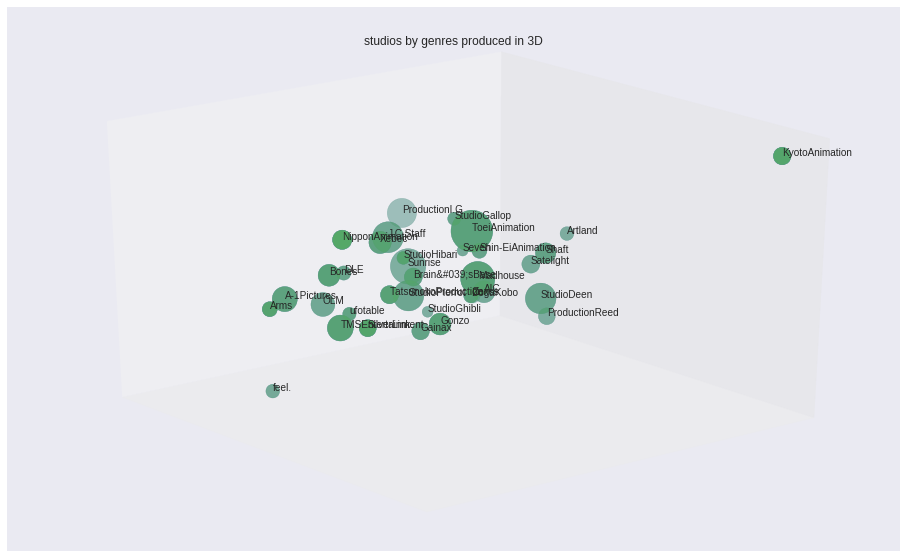

In [119]:
embedder = manifold.TSNE(3, n_iter=1000, n_iter_without_progress=300, init='pca')
embeddings = embedder.fit_transform(studios_genres.div(studios_genres.sum(axis=1), axis=0))

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("studios by genres produced in 3D")
points_3d_to_gif(embeddings, studios_genres.index, 'studios-genres-TSNE', ax, studios_genres.sum(axis=1))

### inspecting genres in time

In [120]:
years_genres = pd.crosstab(animes_genres['aired_from'].dt.year, animes_genres['genre'])

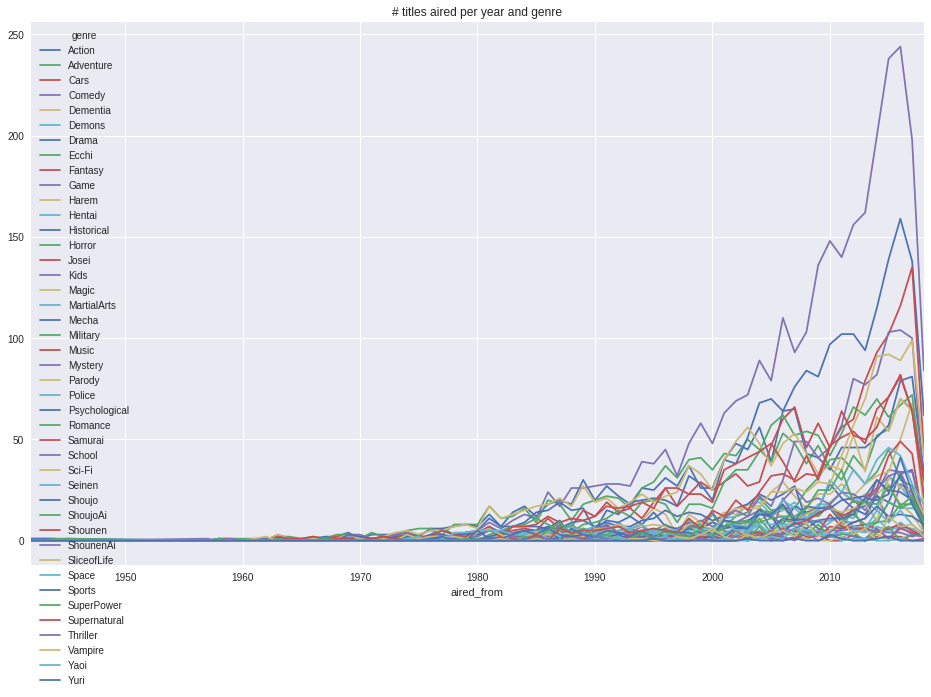

In [121]:
years_genres.plot(figsize=(16, 10), title='# titles aired per year and genre')

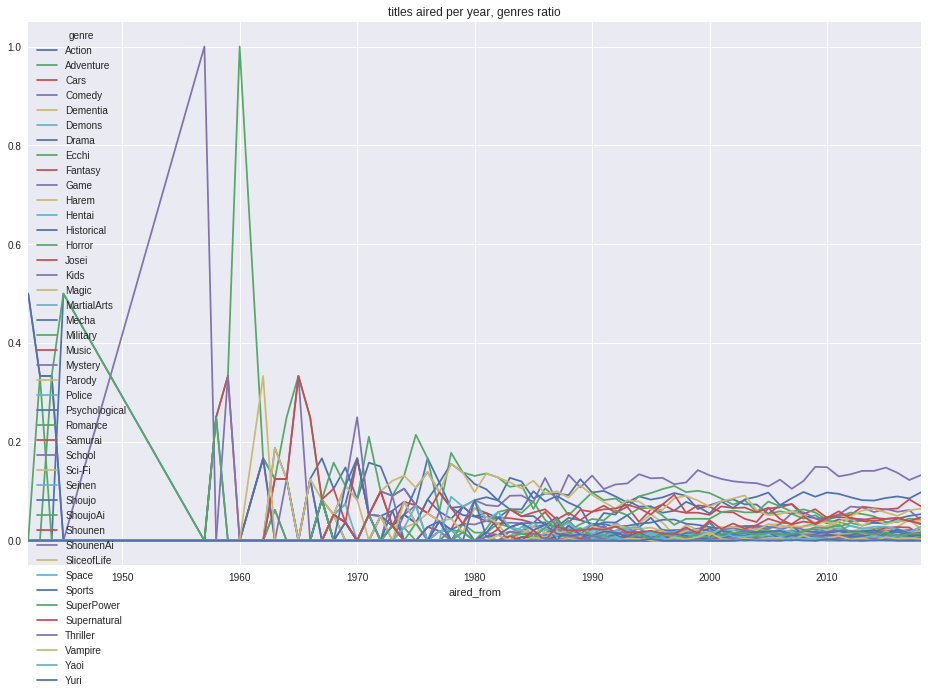

In [122]:
years_genres.div(years_genres.sum(axis=1), axis=0).plot(figsize=(16, 10), title='titles aired per year, genres ratio')

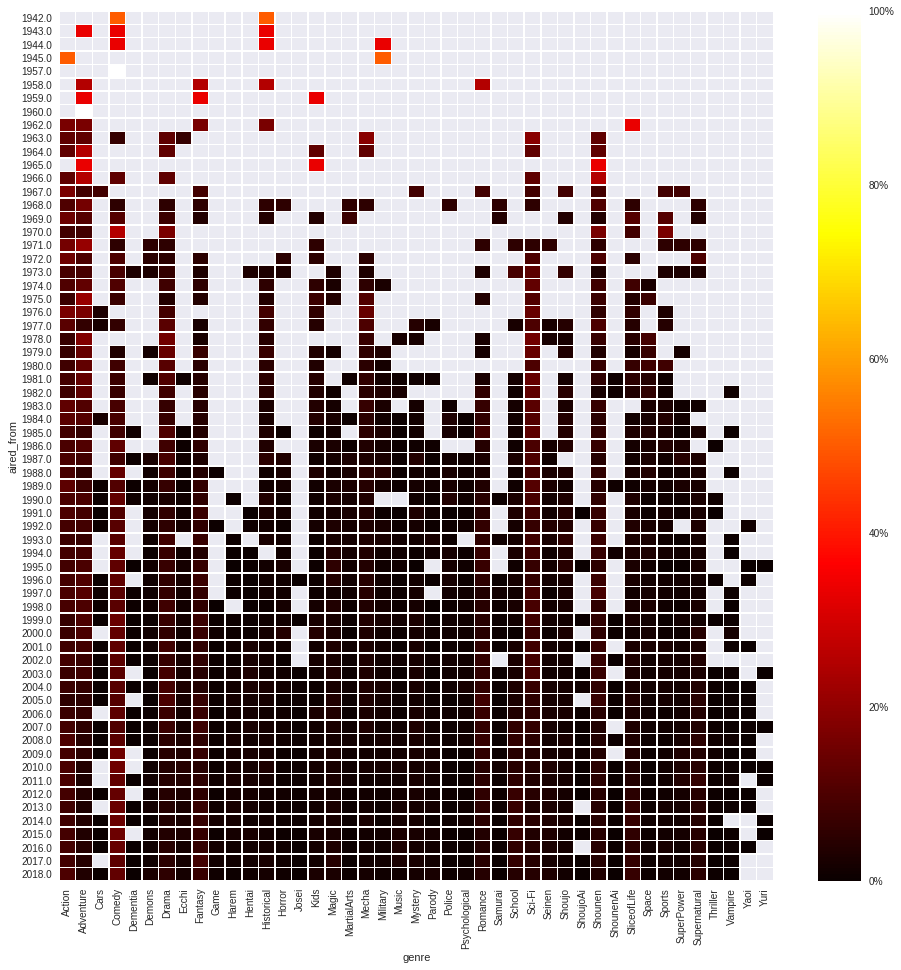

In [123]:
f, ax = plt.subplots(figsize=(16, 16))
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(years_genres.div(years_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})


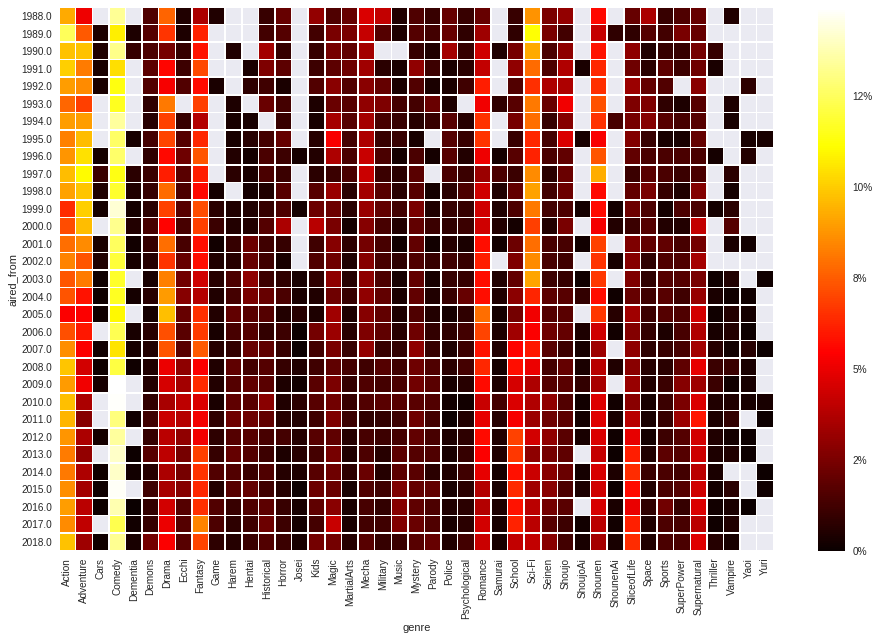

In [124]:
years_genres = years_genres[years_genres.index >= 1988]

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(years_genres.div(years_genres.sum(axis=1), axis=0) * 100, mask=mask, linewidths=.5, cmap=plt.cm.hot, cbar_kws={'format': '%.0f%%'})


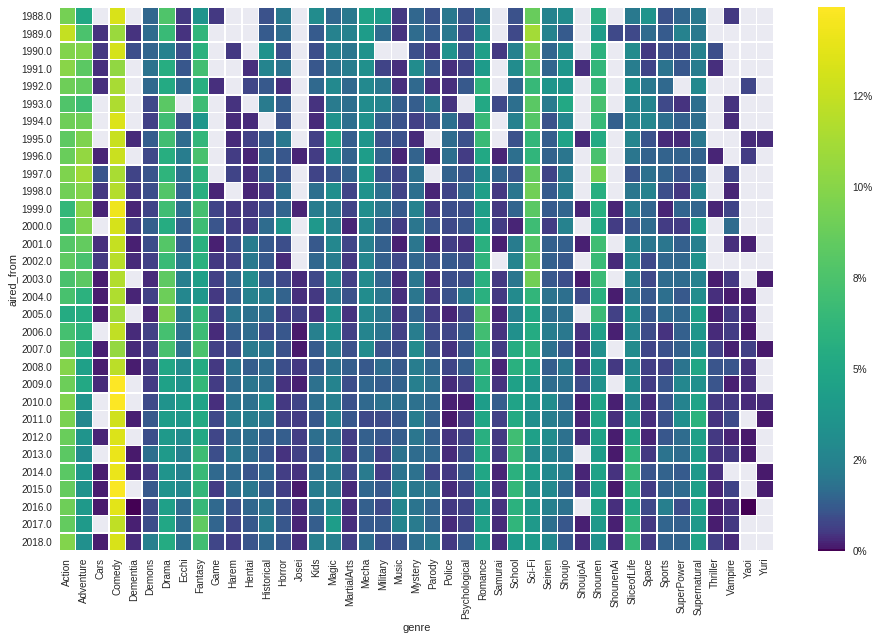

In [125]:
years_genres = years_genres[years_genres.index >= 1988]

f, ax = plt.subplots(figsize=(16, 10))
data = years_genres.div(years_genres.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.viridis, data)
mask = np.zeros_like(years_genres, dtype=np.bool)
mask[years_genres == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

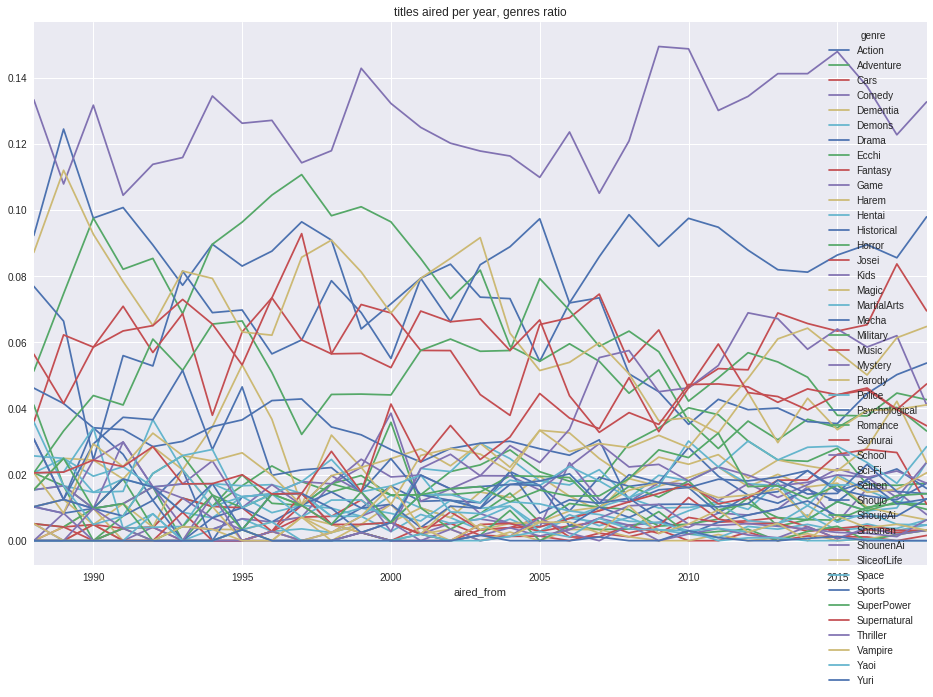

In [126]:
years_genres.div(years_genres.sum(axis=1), axis=0).plot(figsize=(16, 10), title='titles aired per year, genres ratio')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

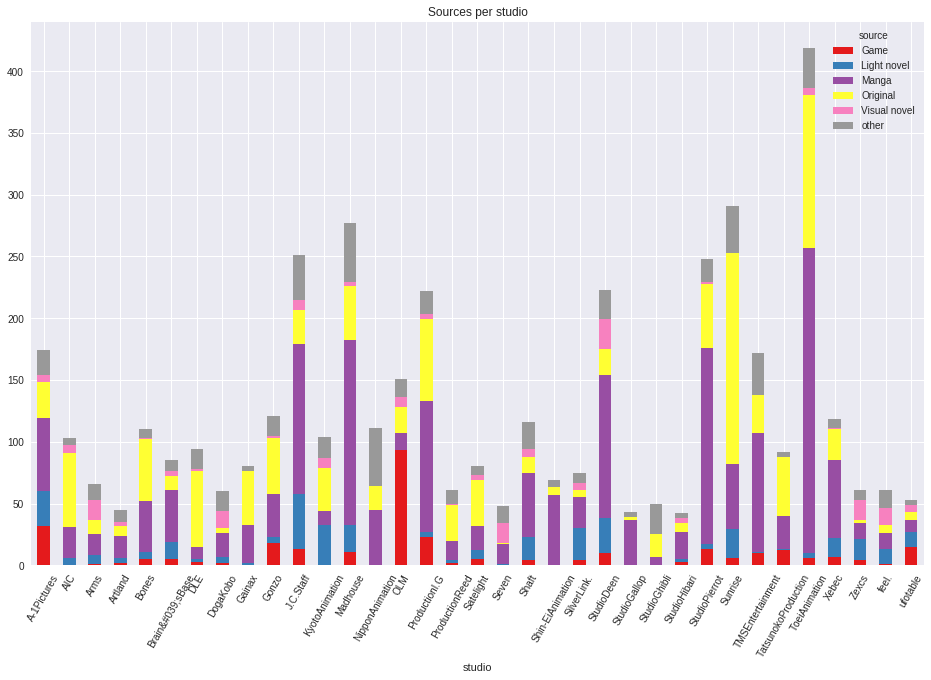

In [127]:
studios_sources = pd.crosstab(animes_studios['studio'], animes_studios['source'])
# keeping only interesting sources
interesting_sources = ['Game', 'Light novel', 'Manga', 'Original', 'Visual novel']
other_sources = list(set(studios_sources.columns) - set(interesting_sources))
studios_sources['other'] = studios_sources[other_sources].sum(axis=1)
studios_sources = studios_sources.drop(other_sources, axis=1)

studios_sources = studios_sources[studios_sources.index.isin(known_studios)]

colors = plt.cm.Set1(np.linspace(0, 1, studios_sources.shape[1]))
studios_sources.plot.bar(stacked=True, figsize=(16, 10), title='Sources per studio', color=colors)
plt.xticks(rotation=60)

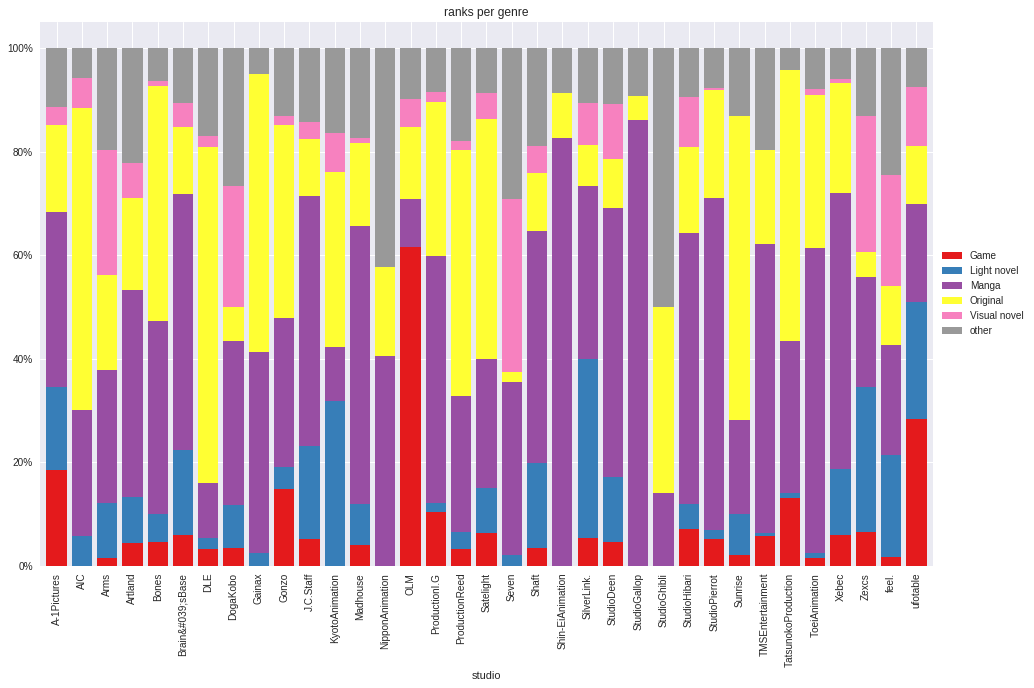

In [128]:
studios_sources.div(studios_sources.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(16, 10), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

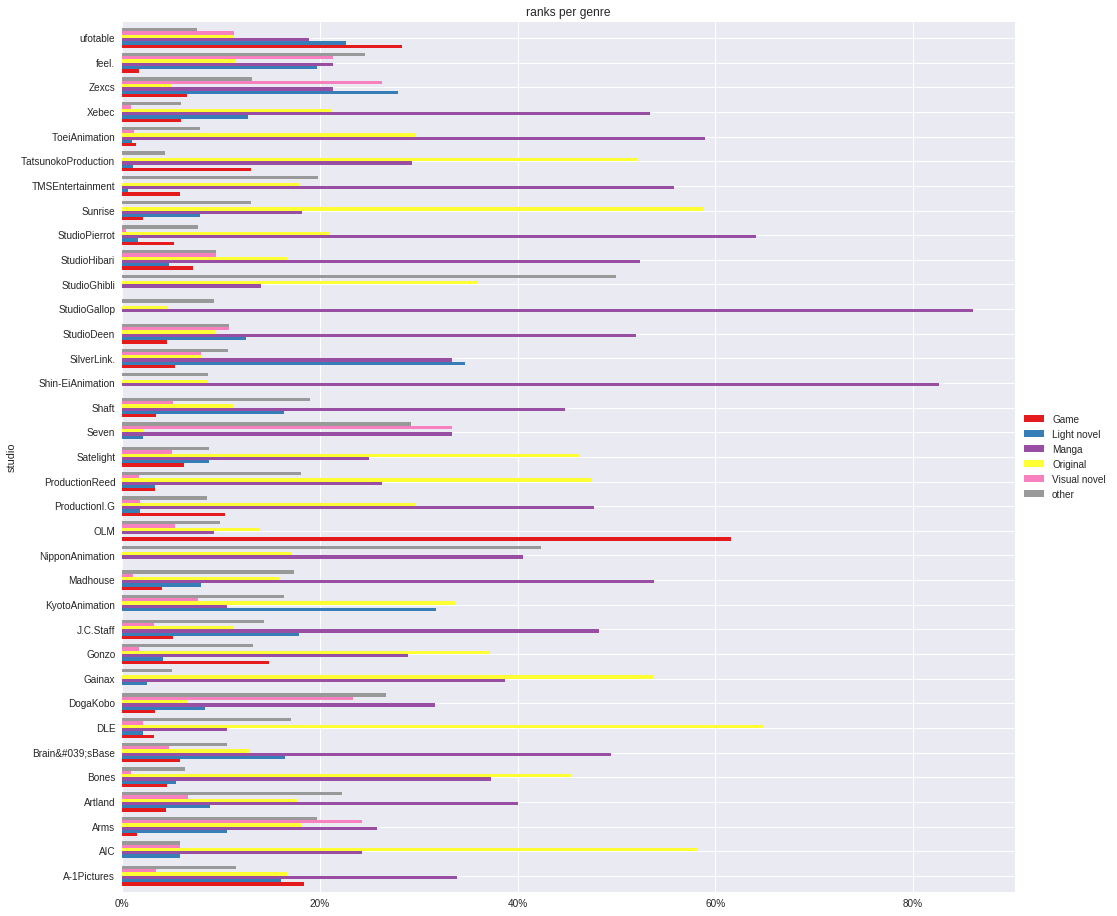

In [129]:
studios_sources.div(studios_sources.sum(axis=1), axis=0).plot(kind='barh', stacked=False, figsize=(16, 16), title='ranks per genre', color=colors, width=0.8)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

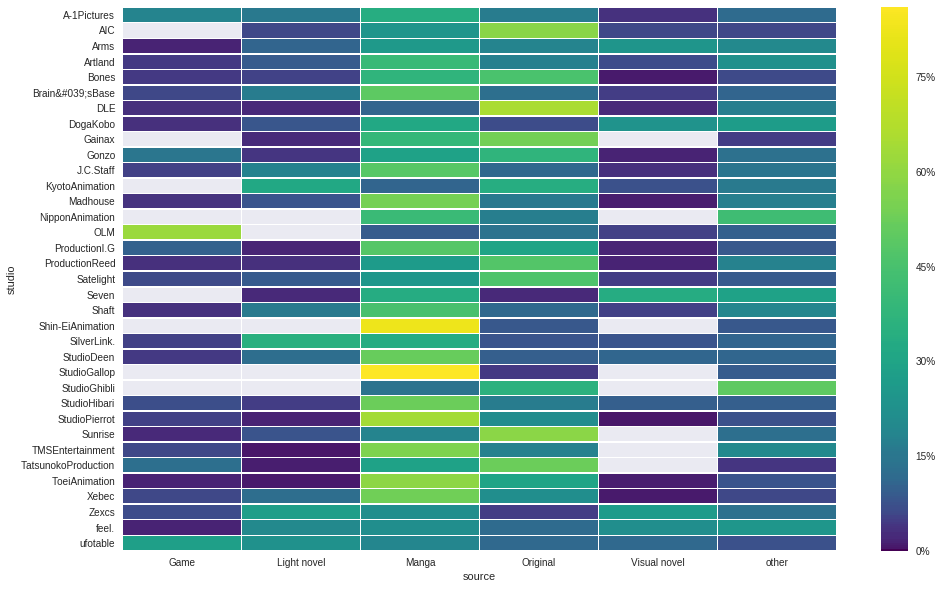

In [130]:
f, ax = plt.subplots(figsize=(16, 10))
data = studios_sources.div(studios_sources.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.viridis, data)
mask = np.zeros_like(studios_sources, dtype=np.bool)
mask[studios_sources == 0] = True
sns.heatmap(data, mask=mask, linewidths=.5, cmap=cmap, cbar_kws={'format': '%.0f%%'})

#### genres similarity based on in how many anime they appear together


In [131]:
genres_animes = pd.crosstab(animes_genres['genre'], animes_genres.index.get_level_values('anime_id'))

In [132]:
genres_animes.head()

col_0      1      5      6      7      8      15     16     17     18     \
genre                                                                      
Action         1      1      1      1      0      1      0      0      1   
Adventure      1      0      1      0      1      0      0      0      0   
Cars           0      0      0      0      0      0      0      0      1   
Comedy         1      0      1      0      0      1      1      1      0   
Dementia       0      0      0      0      0      0      0      0      0   

col_0      19     ...    37802  37814  37858  37859  37860  37886  37888  \
genre             ...                                                      
Action         0  ...        0      0      0      0      0      0      1   
Adventure      0  ...        0      0      0      0      0      0      1   
Cars           0  ...        0      0      0      0      0      0      0   
Comedy         0  ...        0      0      1      1      1      0      0   
Dementia       0  ...        0      0      0      0      0      0      0   

col_0      37894  37895  37896  
genre                           
Action         0      0      0  
Adventure      0      0      0  
Cars           0      0      0  
Comedy         0      0      0  
Dementia       0      0      0  

[5 rows x 6664 columns]

14

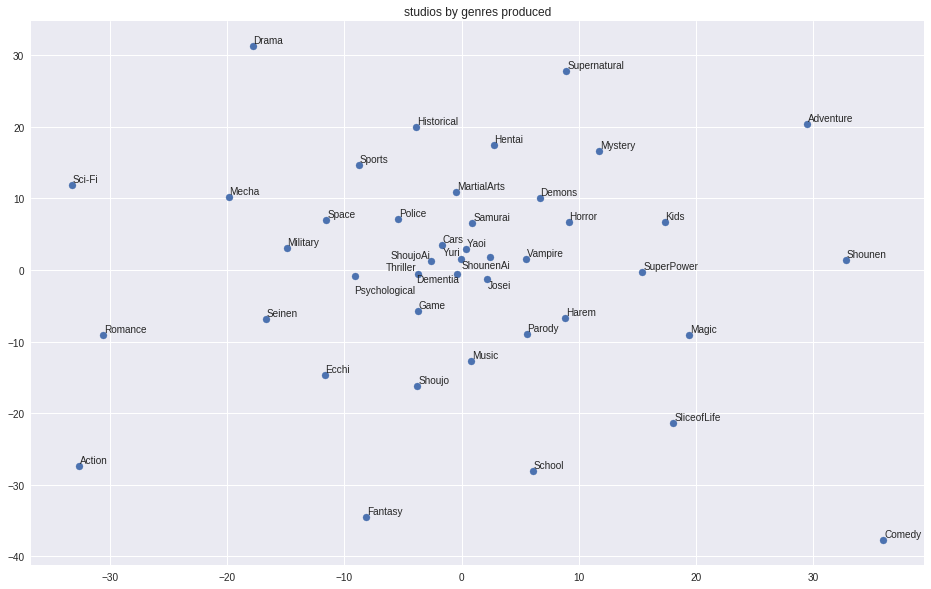

In [133]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5)
embeddings = embedder.fit_transform(genres_animes)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

<IPython.core.display.Javascript object>


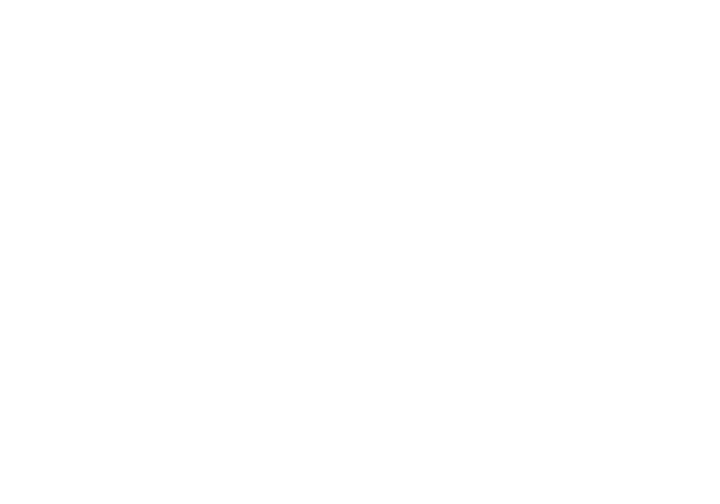

<IPython.core.display.Javascript object>


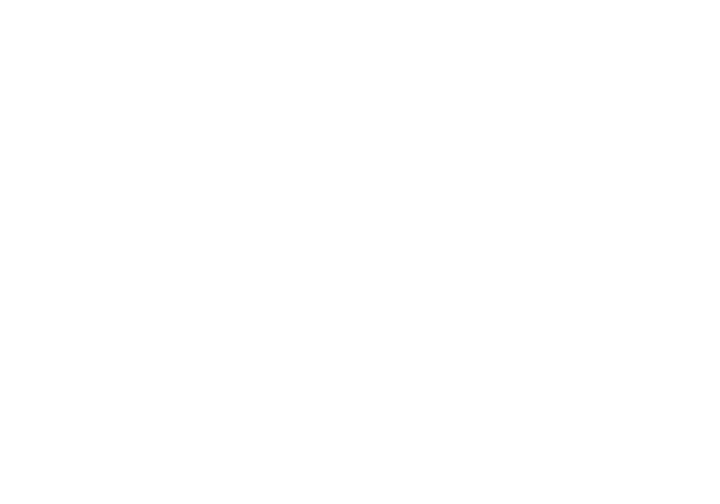

In [134]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=2000, n_init=10)
embeddings = embedder.fit_transform(genres_animes)
plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
#for i, txt in enumerate(genres_animes.index):
#    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)
plt.show()

In [135]:
embeddings

array([[  6.0184634 , -25.68759347,  32.06880156],
       [ -0.30372017, -32.8280377 ,   6.24700154],
       [ -0.92146898,   2.25574552,   1.974184  ],
       [ 49.16156814, -12.18735744,  -7.24448466],
       [ -4.22434772,   0.77711917,   1.00673773],
       [ -4.275317  ,  -8.97342598,  -3.23750496],
       [-26.55195252, -14.58946293,  16.66841598],
       [ 17.1258178 ,  -2.50589483,  -6.03737262],
       [  2.56533412, -31.69963327, -14.7177139 ],
       [ -4.04417848,   8.161297  ,  -8.81297087],
       [  7.63550349,   0.96949542, -10.53462909],
       [-13.88051589,  13.55132114,  -6.33205384],
       [  3.31919626,  17.79712665,   9.56409743],
       [-12.01587068,  -4.89751729,   0.13943946],
       [ -0.86073678,   6.99863164,  -2.86643595],
       [-14.81494794,   2.45113411, -14.49980273],
       [ -2.91906762, -13.60395846, -17.17400924],
       [  5.43847812,  -4.4394798 ,   1.56268044],
       [ -4.73548266,   5.25866989,  21.3284387 ],
       [ -7.52878779,  -2.74691

In [136]:
dists = pdist(genres_animes, 'euclidean')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index
dists_df

genre             Action  Adventure       Cars     Comedy   Dementia  \
genre                                                                  
Action          0.000000  46.151923  45.210618  60.991803  45.628938   
Adventure      46.151923   0.000000  37.121422  56.480085  37.389838   
Cars           45.210618  37.121422   0.000000  55.226805   9.380832   
Comedy         60.991803  56.480085  55.226805   0.000000  55.226805   
Dementia       45.628938  37.389838   9.380832  55.226805   0.000000   
Demons         45.254834  38.078866  16.248077  55.497748  16.370706   
Drama          50.626080  46.162756  36.891733  59.674115  36.810325   
Ecchi          47.212287  41.940434  23.388031  52.905576  23.430749   
Fantasy        47.539457  39.038443  38.496753  57.183914  38.392708   
Game           45.793013  37.775654  14.456832  55.668663  14.662878   
Harem          46.893496  40.087405  17.804494  53.972215  17.972201   
Hentai         48.579831  40.963398  19.287302  57.758116  19.390719   
Historical     46.583259  39.140772  21.587033  56.692151  21.633308   
Horror         45.497253  38.884444  16.370706  56.284989  15.811388   
Josei          45.672749  37.496667  10.392305  54.972721  10.677078   
Kids           48.114447  37.960506  21.000000  54.726593  21.283797   
Magic          46.829478  39.962482  25.396850  55.362442  25.514702   
MartialArts    43.931765  37.682887  15.297059  55.443665  15.427249   
Mecha          43.451122  39.749214  24.083189  57.515215  24.000000   
Military       44.034078  39.281039  18.788294  57.017541  18.894444   
Music          48.083261  40.718546  19.235384  56.550862  19.131126   
Mystery        46.957428  40.162171  22.248595  56.435804  21.977261   
Parody         47.031904  39.949969  17.435596  53.103672  17.492856   
Police         45.232732  37.443290  13.711309  54.918121  14.071247   
Psychological  46.335731  39.102430  15.716234  56.364883  14.594520   
Romance        52.896125  46.754679  34.871192  53.907328  34.871192   
Samurai        44.687806  37.509999  11.958261  55.181519  12.206556   
School         52.048055  47.927028  32.295511  52.488094  32.357379   
Sci-Fi         44.170126  43.393548  36.701499  58.660038  36.619667   
Seinen         46.572524  41.291646  21.794495  55.000000  22.693611   
Shoujo         48.692915  41.218928  21.931712  55.794265  22.022716   
ShoujoAi       45.639895  37.536649   9.848858  54.981815  10.049876   
Shounen        46.162756  40.706265  34.626579  52.621288  35.057096   
ShounenAi      45.694639  37.496667   9.797959  54.899909  10.000000   
SliceofLife    54.000000  46.818800  31.080541  52.971691  31.176915   
Space          44.721360  38.209946  16.970563  56.338264  17.088007   
Sports         47.106263  40.533936  18.027756  55.181519  19.621417   
SuperPower     42.848571  39.064050  20.199010  55.063600  20.346990   
Supernatural   46.486557  43.646306  30.016662  56.771472  29.681644   
Thriller       45.519227  37.762415  10.954451  55.533774  10.862780   
Vampire        45.310043  37.934153  11.874342  55.090834  12.124356   
Yaoi           45.552168  37.188708   8.306624  55.072679   8.660254   
Yuri           45.354162  36.945906   7.141428  55.018179   7.549834   

genre             Demons      Drama      Ecchi    Fantasy       Game  \
genre                                                                  
Action         45.254834  50.626080  47.212287  47.539457  45.793013   
Adventure      38.078866  46.162756  41.940434  39.038443  37.775654   
Cars           16.248077  36.891733  23.388031  38.496753  14.456832   
Comedy         55.497748  59.674115  52.905576  57.183914  55.668663   
Dementia       16.370706  36.810325  23.430749  38.392708  14.662878   
Demons          0.000000  38.820098  26.134269  38.157568  19.467922   
Drama          38.820098   0.000000  41.833001  47.318073  38.470768   
Ecchi          26.134269  41.833001   0.000000  41.460825  25.651511   
Fantasy        38.157568  47.318073  41

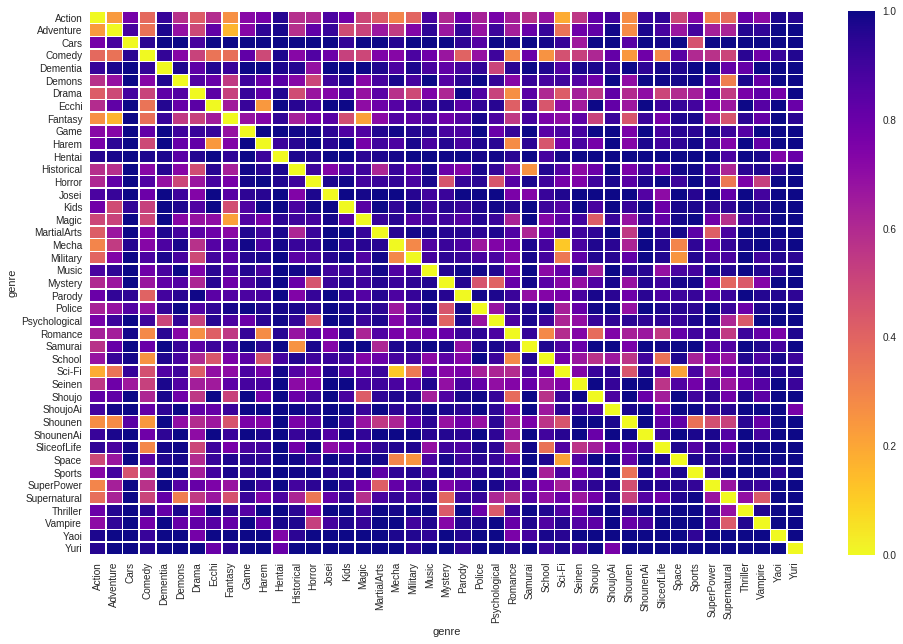

In [137]:
%matplotlib inline
dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

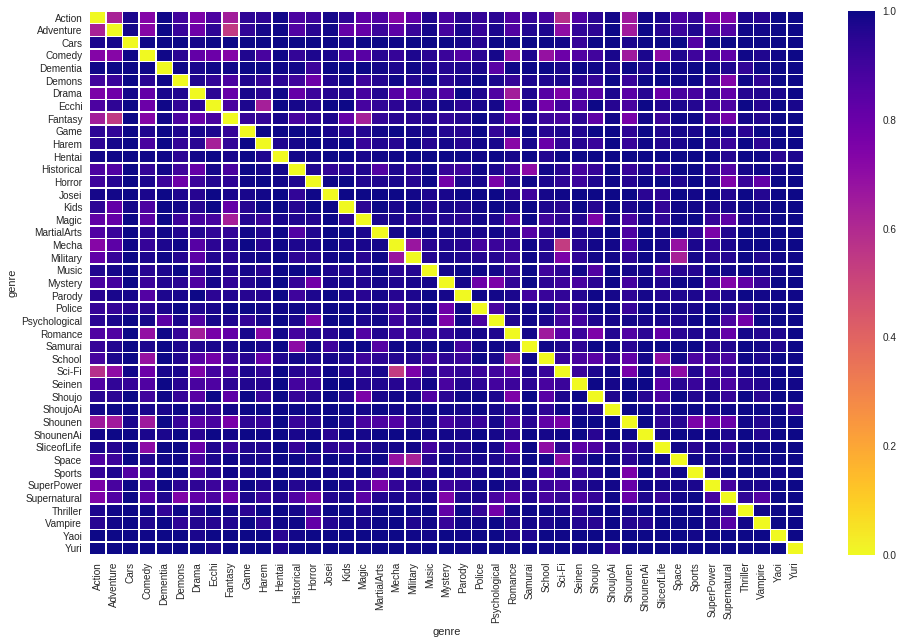

In [138]:
%matplotlib inline
dists = pdist(genres_animes, 'dice')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

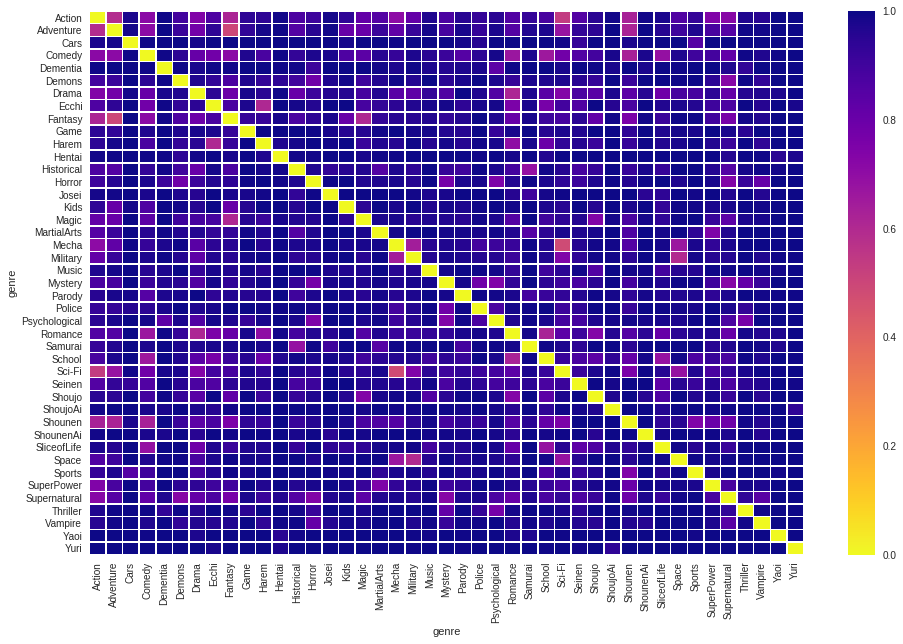

In [139]:
%matplotlib inline
dists = pdist(genres_animes, lambda x, y: 1 - (x & y).sum() / (x | y).sum())
dists_m = squareform(dists) ** 2
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

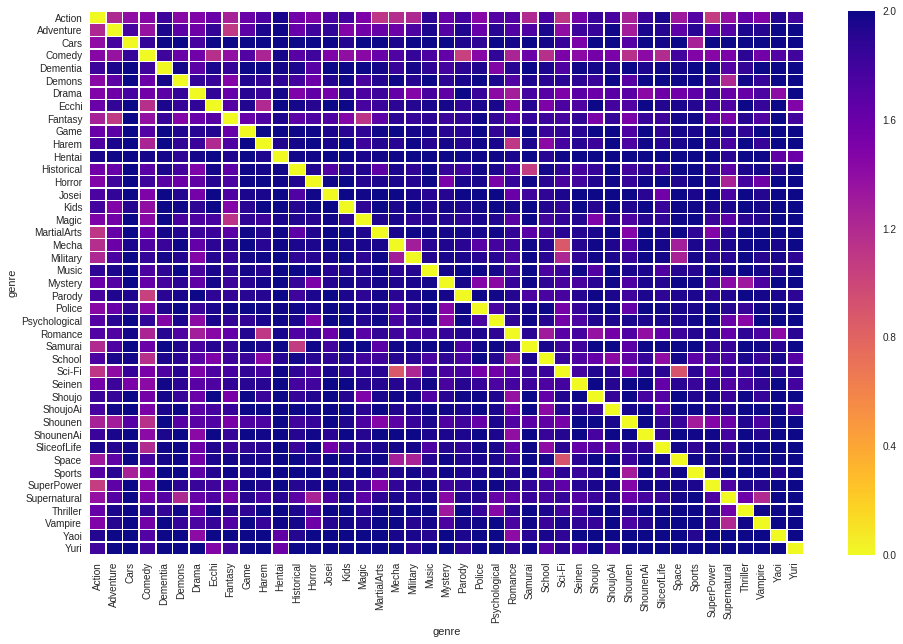

In [140]:
%matplotlib inline
dists = pdist(genres_animes, lambda x, y: 2 - ((x & y).sum() / x.sum() + (x & y).sum() / y.sum()))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)

## using normalized social distance
by Šlerka http://databoutique.cz/

![title](http://stromateis.eu/dbblog/nsd.png)
well, basically it is the normalized web distance
Interesting fact is that it gives infinite distance for disjunctive genres, allowing to produce sparse graph for embedding

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


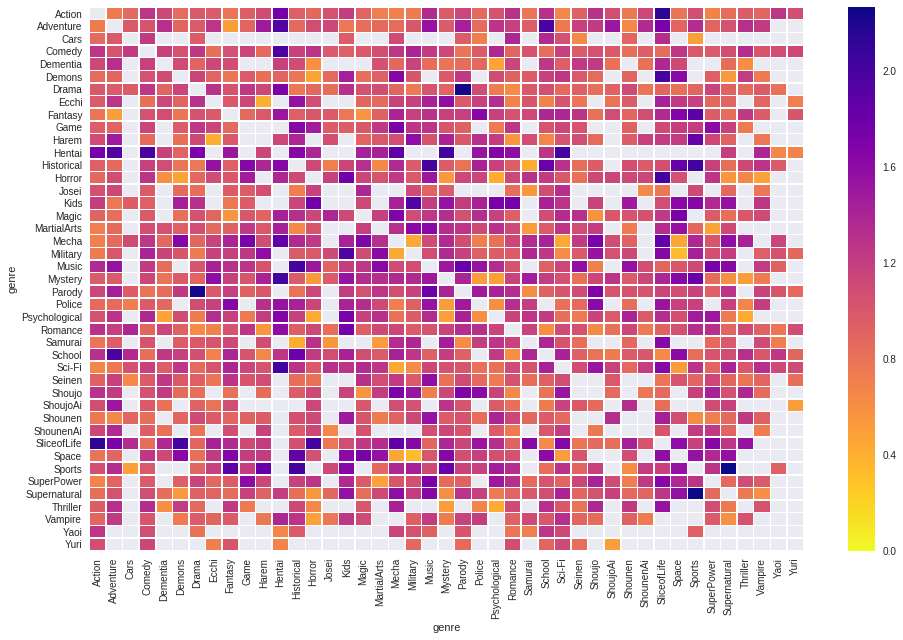

In [141]:
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

%matplotlib inline
dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.plasma_r)

In [142]:
dists_df

genre            Action  Adventure      Cars    Comedy  Dementia    Demons  \
genre                                                                        
Action         0.000000   0.733085  0.873721  1.270502  1.119555  0.853234   
Adventure      0.733085   0.000000  0.984959  1.022117  1.315700  0.898558   
Cars           0.873721   0.984959  0.000000  1.222098  0.000000  0.000000   
Comedy         1.270502   1.022117  1.222098  0.000000  1.173947  1.061614   
Dementia       1.119555   1.315700  0.000000  1.173947  0.000000  1.091404   
Demons         0.853234   0.898558  0.000000  1.061614  1.091404  0.000000   
Drama          0.998188   0.979856  0.982479  1.260870  0.906456  1.148880   
Ecchi          0.979937   1.272230  0.000000  0.820884  1.116880  0.909852   
Fantasy        0.785457   0.513456  0.000000  1.059894  1.075258  0.773761   
Game           0.955087   0.907579  0.000000  1.142961  0.000000  0.982313   
Harem          1.088919   1.484466  0.000000  0.865510  0.000000  0.820412   
Hentai         1.741361   1.940230  0.000000  1.976415  1.171121  0.910742   
Historical     0.943053   0.868801  0.000000  1.184337  1.081669  0.770641   
Horror         0.882281   1.081871  0.000000  1.279607  0.593429  0.469875   
Josei          1.055157   1.115730  0.000000  0.981967  0.000000  0.874145   
Kids           1.202022   0.763506  0.964022  0.942798  0.000000  1.444599   
Magic          0.909519   0.838460  0.000000  0.990692  0.000000  0.822021   
MartialArts    0.725577   0.861903  0.000000  1.062980  1.062241  0.939563   
Mecha          0.701778   0.854543  1.100780  1.260810  0.878262  1.649532   
Military       0.741309   1.007497  0.000000  1.404478  1.159189  1.012691   
Music          1.362750   1.544535  0.000000  1.224102  0.845043  0.000000   
Mystery        0.973596   0.977744  0.000000  1.130373  0.791404  0.984754   
Parody         1.136318   1.444290  0.961342  0.795102  0.847936  1.236556   
Police         0.862540   0.856828  0.718366  0.965506  0.878076  0.000000   
Psychological  1.040888   1.276813  0.000000  1.379068  0.470729  1.092370   
Romance        1.300905   1.187175  1.388894  0.889715  1.147367  0.923938   
Samurai        0.782240   0.955301  0.000000  1.040741  0.000000  0.962047   
School         1.306469   1.995833  1.357666  0.824058  1.255185  1.183696   
Sci-Fi         0.655451   0.760624  1.059166  1.176302  0.948456  1.263796   
Seinen         0.926032   1.175534  0.640822  0.966272  1.241891  0.994949   
Shoujo         1.299532   1.229111  0.000000  1.050258  1.228577  0.856185   
ShoujoAi       1.075757   1.508971  0.000000  0.987107  0.812492  0.000000   
Shounen        0.759953   0.650346  0.901619  0.831603  0.000000  0.892447   
ShounenAi      1.131686   1.358811  0.000000  0.954601  0.808855  0.000000   
SliceofLife    2.125247   1.726163  1.341992  0.844581  1.378987  2.010993   
Space          0.795772   0.894931  0.000000  1.263455  1.112036  1.621695   
Sports         1.067753   1.339183  0.496417  0.991839  0.000000  0.000000   
SuperPower     0.673571   0.905997  0.000000  0.976698  0.000000  0.941132   
Supernatural   0.829852   1.058894  0.000000  1.082901  0.846126  0.536443   
Thriller       0.960262   1.313467  0.000000  1.337963  0.602131  1.219197   
Vampire        0.889257   1.222134  0.000000  1.012583  0.000000  0.739310   
Yaoi           1.266921   0.000000  0.000000  1.084358  0.000000  0.000000   
Yuri           1.066295   0.000000  0.000000  1.125857  0.000000  0.000000   

genre             Drama     Ecchi   Fantasy      Game    ...     ShounenAi  \
genre                                                    ...                 
Action         0.998188  0.979937  0.785457  0.955087    ...      1.131686   
Adventure      0.979856  1.272230  0.513456  0.907579    ...      1.358811   
Cars           0.982479  0.000000  0.000000  0.000000    ...      0.000000   
Comedy         1.260870  0.820884  1.059894  1.142961    ...      0.954601   
Dementia       0.9064

In [143]:
x = genres_animes.loc['Mecha']
y = genres_animes.loc['Sci-Fi']
y = genres_animes.loc['Mecha']
print(1 - (x & y).sum() / (x | y).sum())
print((x & y).sum() / (x | y).sum())


0.0
1.0


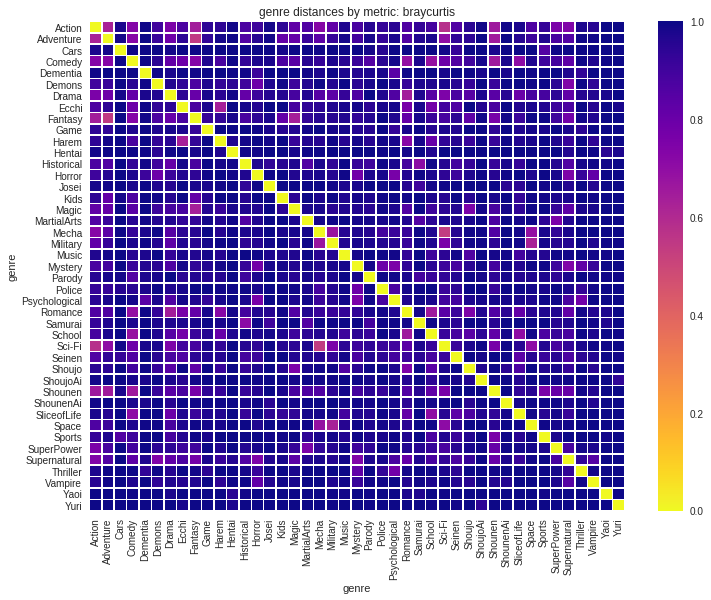

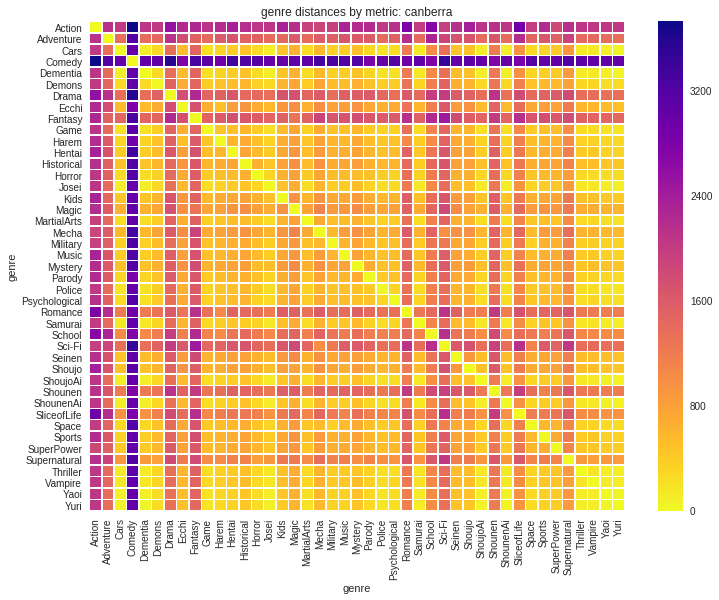

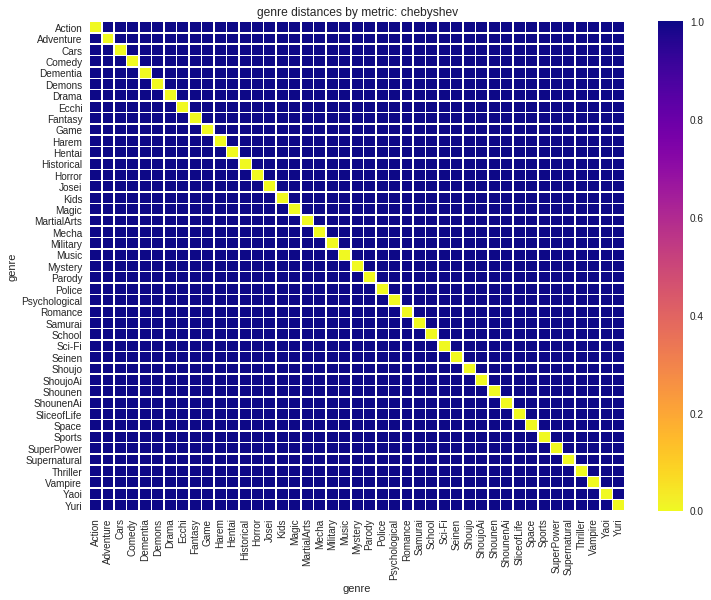

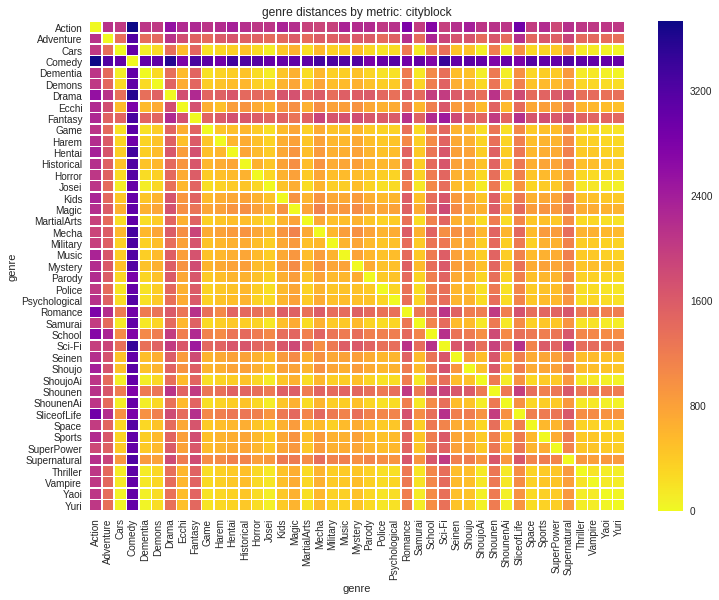

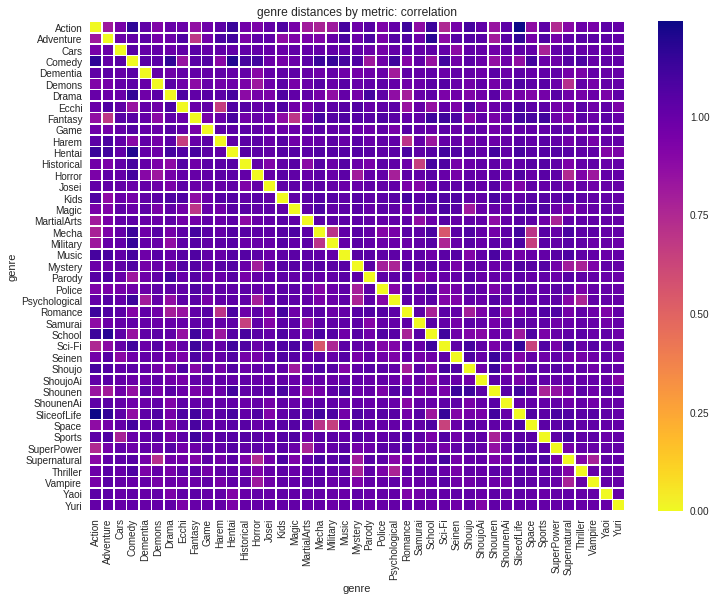

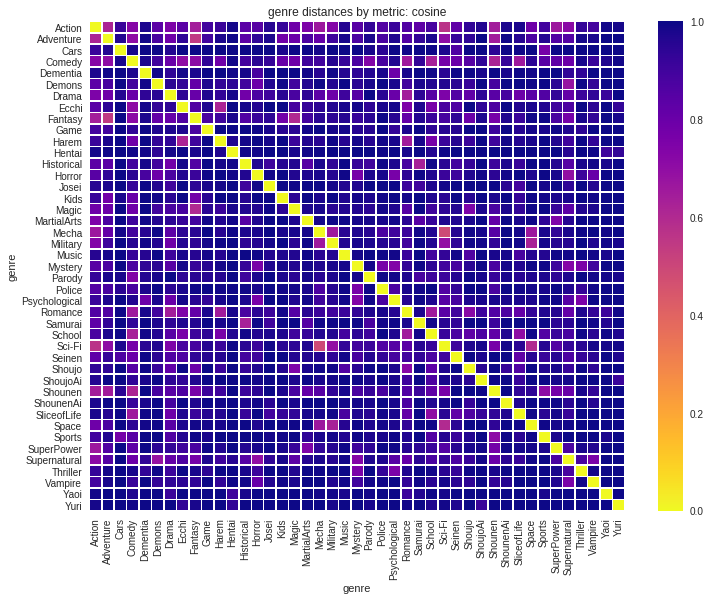

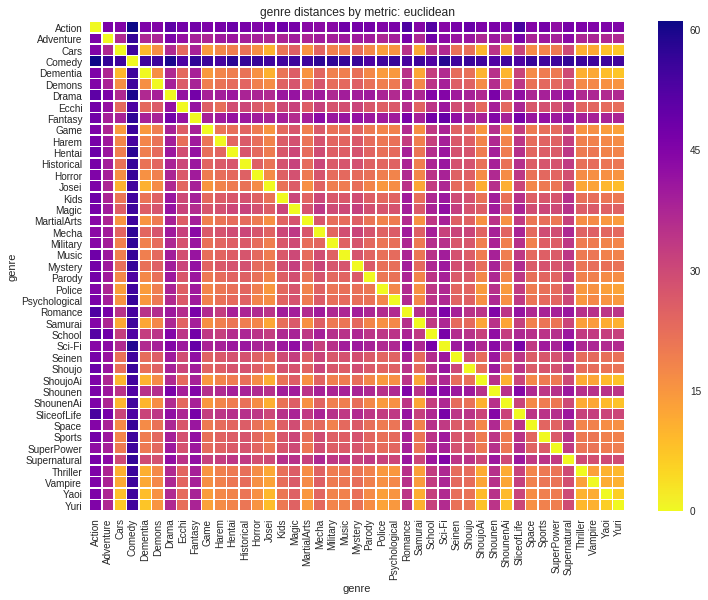

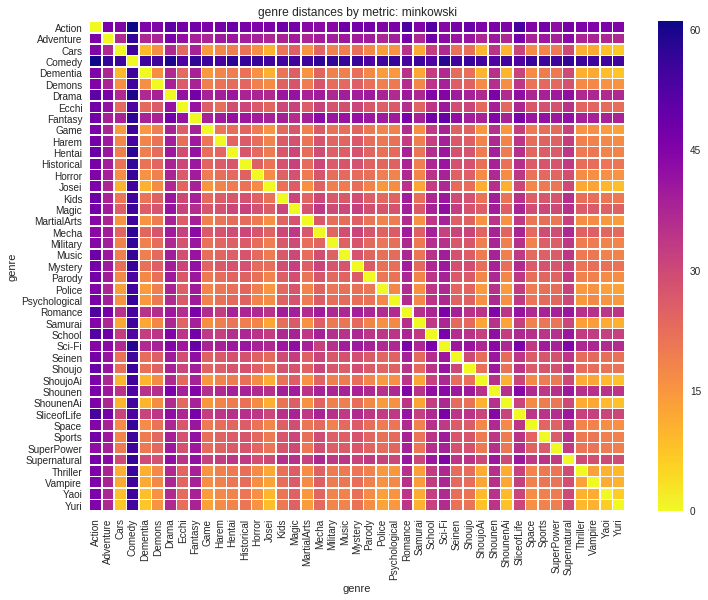

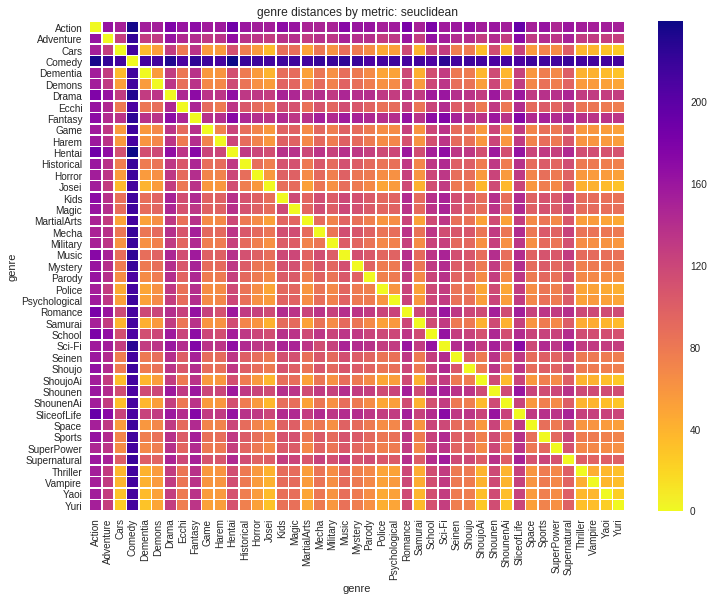

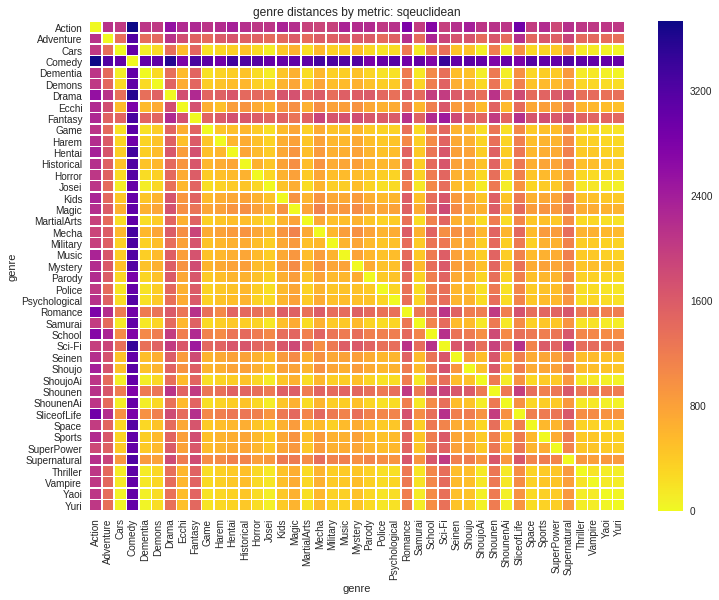

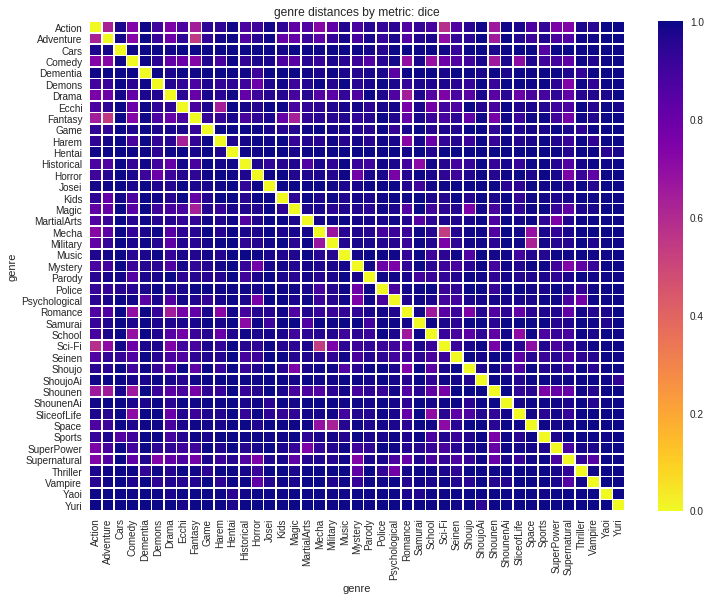

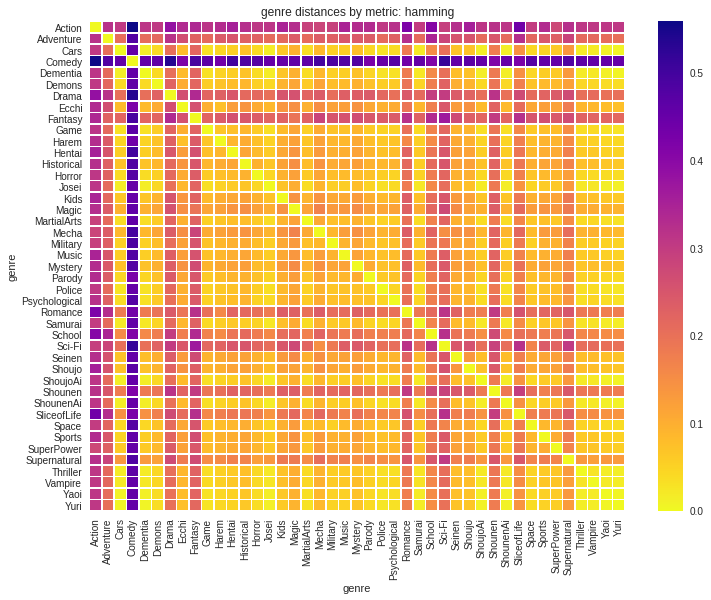

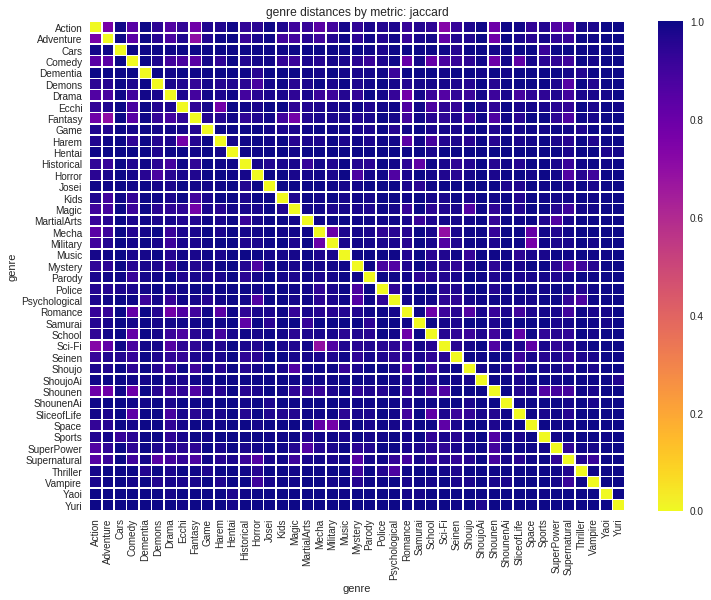

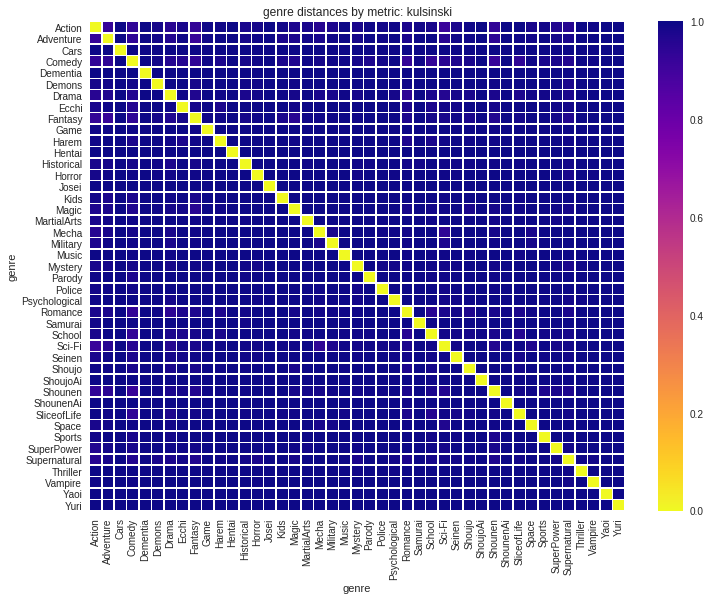

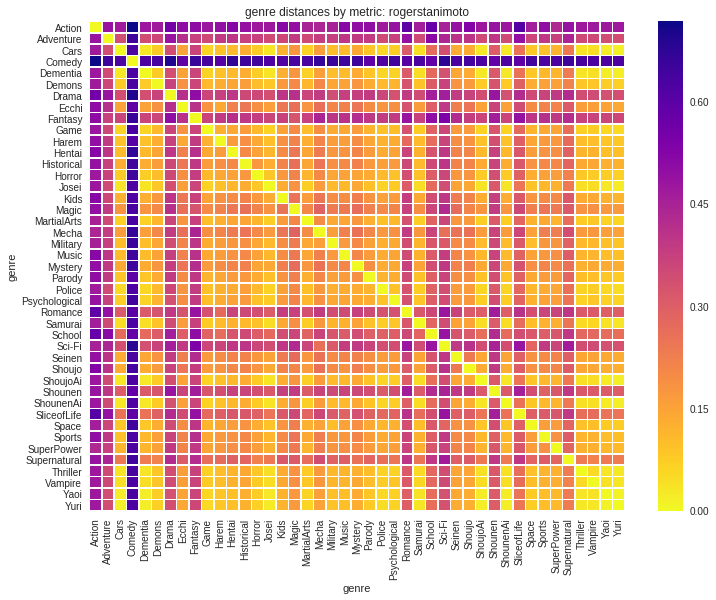

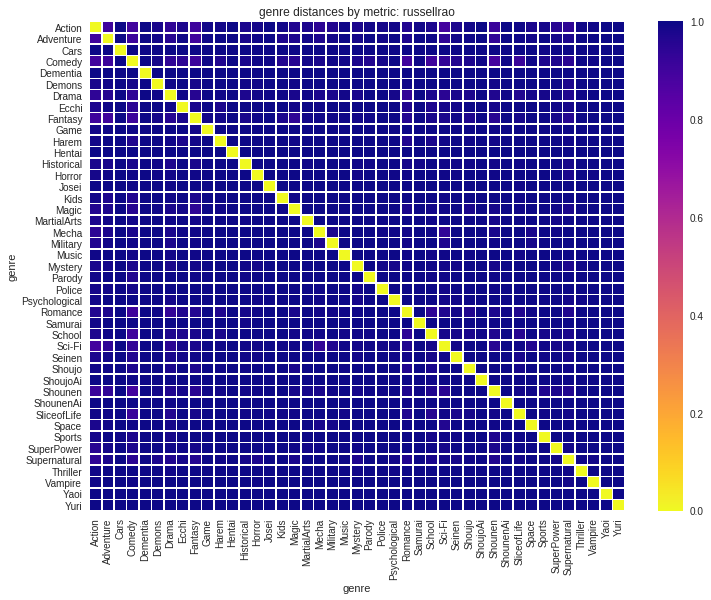

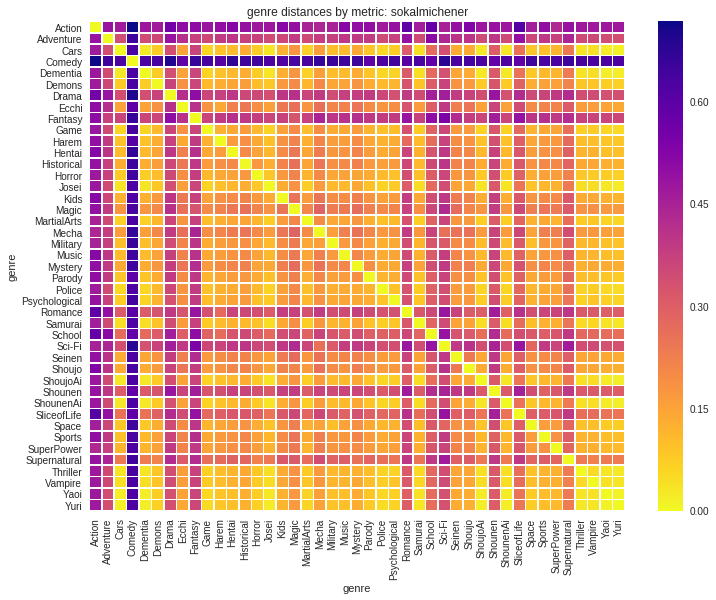

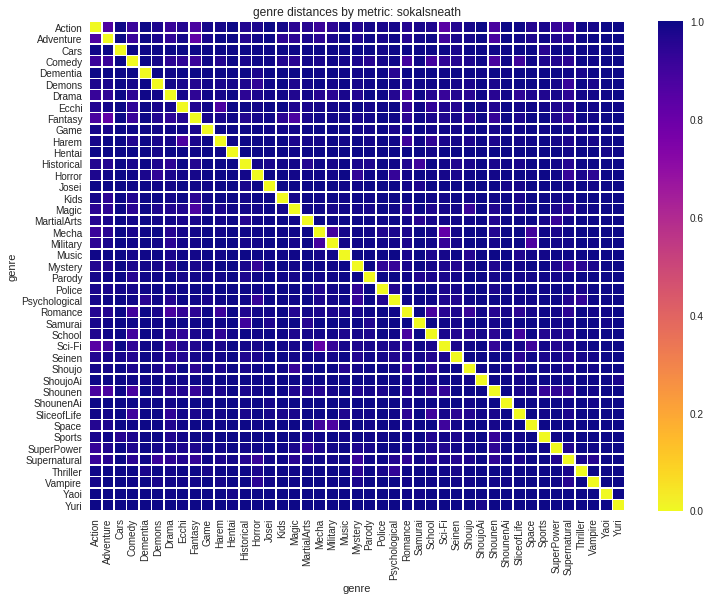

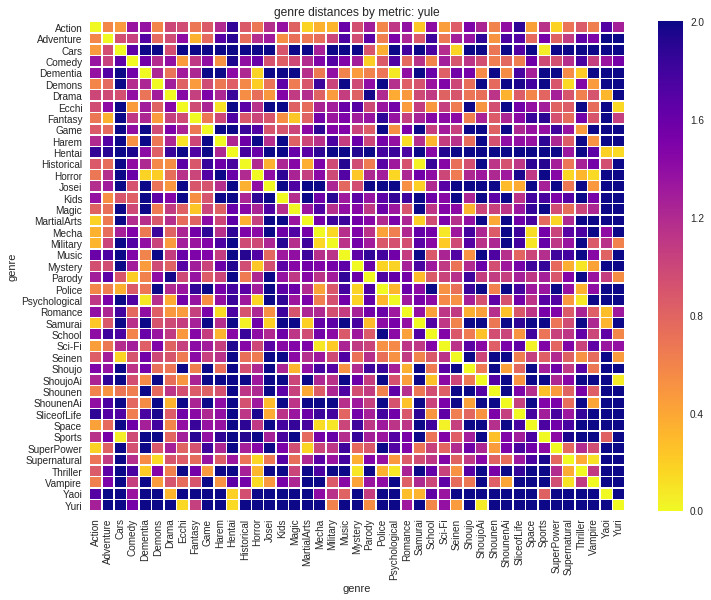

In [144]:
def show_distances(metric):
    dists = pdist(genres_animes, metric)
    dists_m = squareform(dists)
    dists_df = pd.DataFrame(dists_m)
    dists_df.columns = genres_animes.index
    dists_df.index = genres_animes.index

    f, ax = plt.subplots(figsize=(12, 9))
    plt.title('genre distances by metric: {}'.format(metric))
    sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.plasma_r)
    plt.show()
    
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'minkowski', 
        'seuclidean', 'sqeuclidean', 'dice', 'hamming', 'jaccard', 'kulsinski', 'rogerstanimoto', 'russellrao',
        'sokalmichener', 'sokalsneath', 'yule']

for metric in metrics:
    show_distances(metric)

6

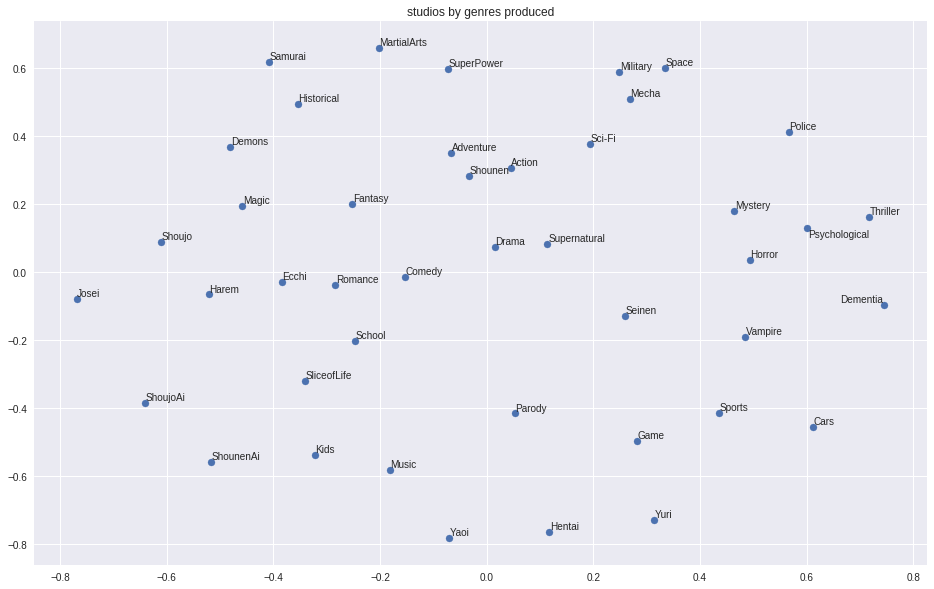

In [145]:
%matplotlib inline

dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

6

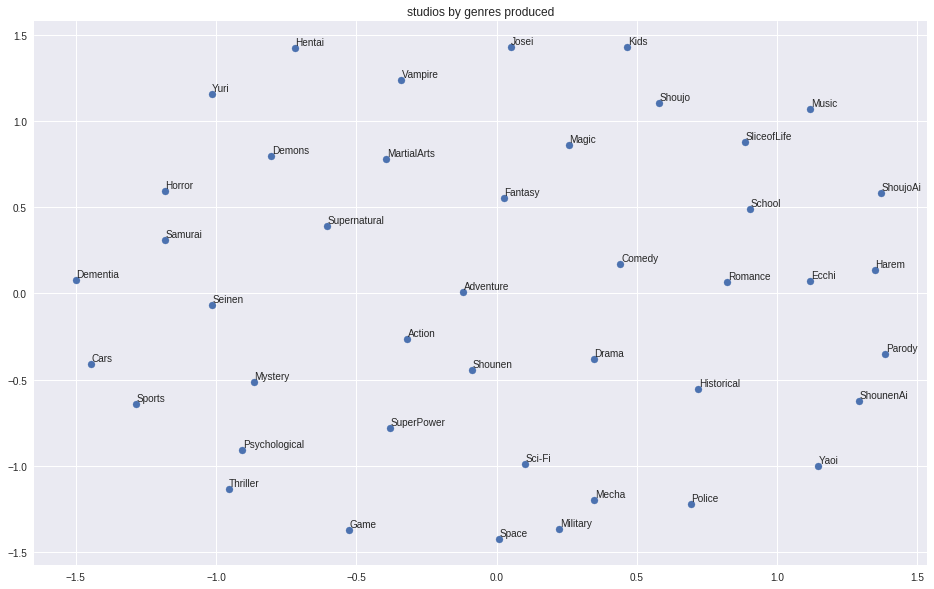

In [146]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: 2 - ((x & y).sum() / x.sum() + (x & y).sum() / y.sum()))
dists_m = squareform(dists)
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


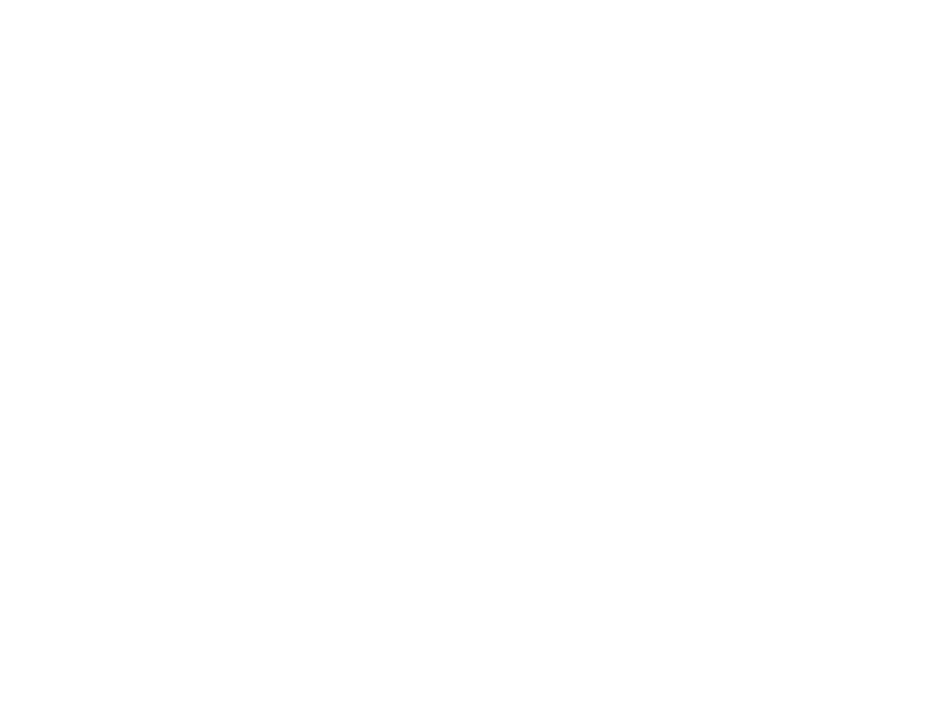

In [147]:
%matplotlib notebook

embedder = manifold.MDS(3, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

plt.figure(figsize=(13, 10))

ax = plt.axes(projection='3d')
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
for i, txt in enumerate(genres_animes.index):
    ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)
plt.show()

In [148]:
embeddings

array([[ 0.21933582,  0.59867275,  0.12450639],
       [ 0.05092155,  0.76761371,  0.63330637],
       [ 0.84502013,  0.18265901, -1.11338411],
       [ 0.34942896, -0.35142364, -0.00414677],
       [-1.34503739,  0.09127236, -0.38573096],
       [-0.5630404 ,  0.5684051 ,  1.04575938],
       [-0.56980064, -0.15775247, -0.35894976],
       [ 0.88967538, -0.72291041,  0.35859961],
       [-0.15888495,  0.01999259,  0.91065721],
       [ 1.00615059,  0.80304704, -0.54819812],
       [ 0.54764044, -1.12525901,  0.23528455],
       [ 0.30324513, -0.88518374,  1.13895138],
       [ 0.31414834,  0.5943846 ,  1.11210346],
       [-1.13122104,  0.64664345,  0.16883572],
       [-0.22850574, -1.24373684,  0.48971127],
       [-0.17413068, -0.28876061,  1.35882539],
       [-0.63736149, -0.50224128,  0.8829345 ],
       [ 0.9853101 ,  0.35711044,  0.79463548],
       [-0.07876343,  1.19782059, -0.45108866],
       [-0.40809399,  1.2419148 ,  0.13786633],
       [-0.80620156, -0.62391575, -0.953

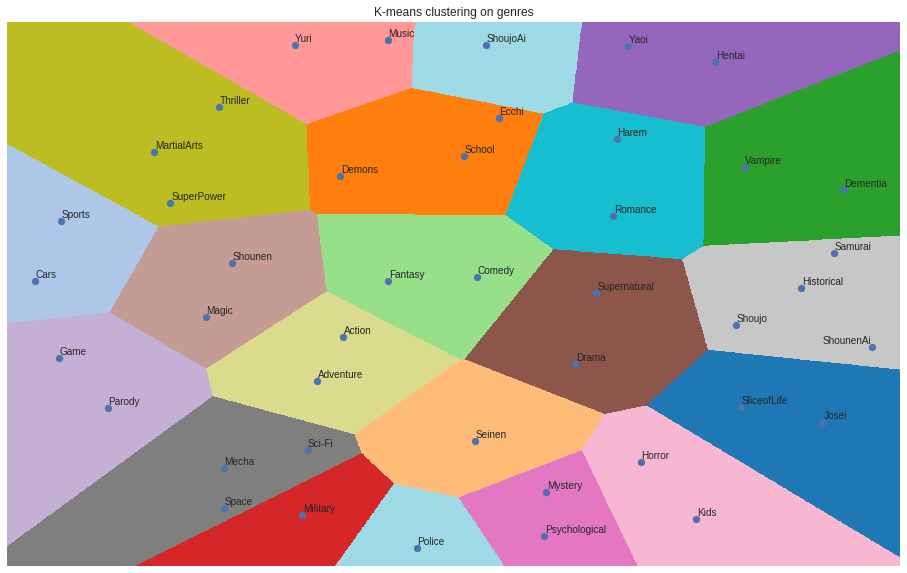

In [149]:
%matplotlib inline
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
dists = pdist(genres_animes, 'cosine')
dists_m = squareform(dists) ** 3
Z = linkage(squareform(dists_m), 'ward')

In [151]:
# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=genres_animes.index
)
plt.show()

In [152]:
np.log(0)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


6

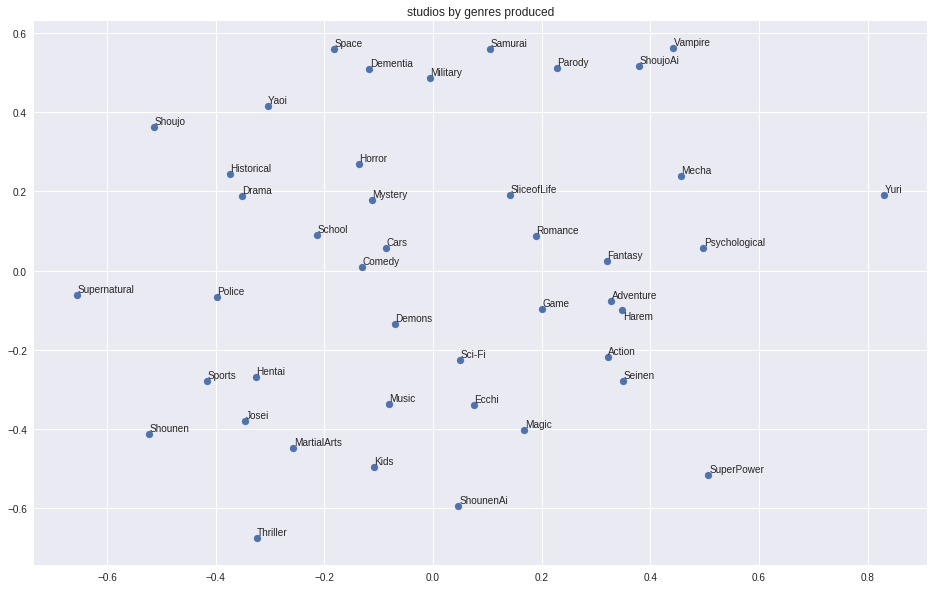

In [153]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(2, metric=False, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


321

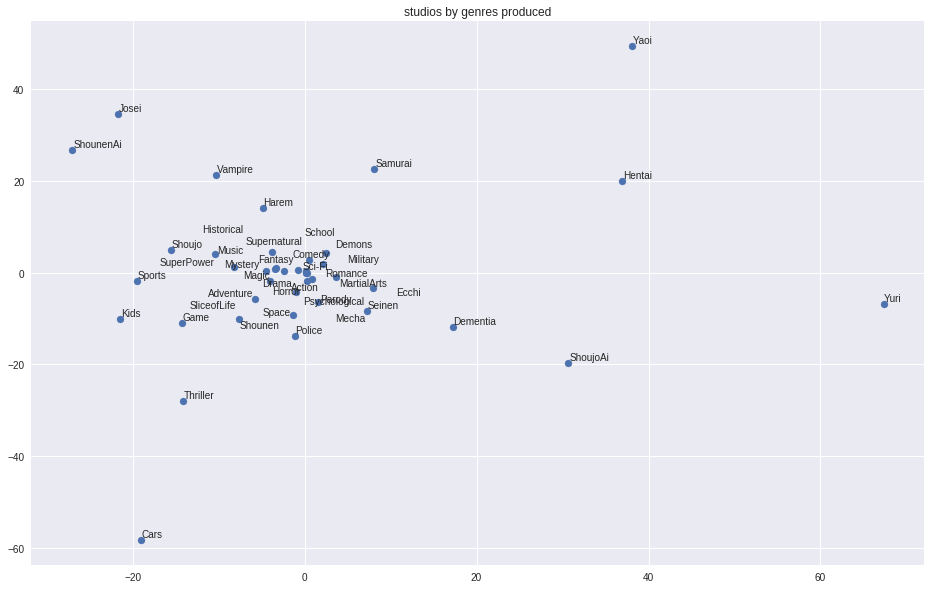

In [154]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 100
embedder = manifold.MDS(2, metric=True, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("studios by genres produced")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(genres_animes.index)]
adjust_text(texts)

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


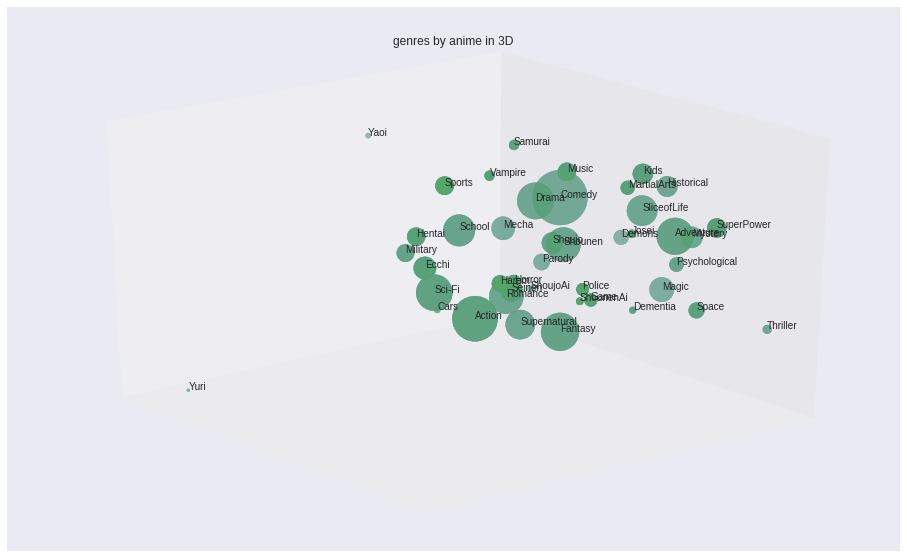

In [155]:
%matplotlib inline

dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.title("genres by anime in 3D")
points_3d_to_gif(embeddings, genres_animes.index, 'genres-NSD-MSD', ax, genres_animes.sum(axis=1))

In [156]:
# now using networkx to visualize it
#df = pd.DataFrame(ints, columns=['weight', 'cost'])
dists = pdist(genres_animes, lambda x, y: nsd(x, y))
pairs = np.array(list(combinations(genres_animes.index, 2)))

#nodes = pd.DataFrame({'id': studios_genres.index, 'label': studios_genres.index})
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': dists})
edges = edges[edges['weight'] != np.inf]

G = nx.from_pandas_dataframe(edges, 'source', 'target', 'weight')

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [157]:
pos = nx.fruchterman_reingold_layout(G, dim=2, weight='weight', iterations=5000)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, with_labels=True)
plt.show()

/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home.others/eb/easybuild/software/scikit-image/0.13.1-goolfc-2018a-Python-3.6.4/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) =

In [158]:
G['Action']['Adventure']['weight']

0.7330849073516265

In [159]:
nodes = pd.DataFrame({'id': genres_animes.index, 'label': genres_animes.index})
edges['type'] = 'undirected'
    
nodes.to_csv('genres_animes_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_animes_edges_NSD.csv', index=False, sep=',', encoding='utf-8')

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


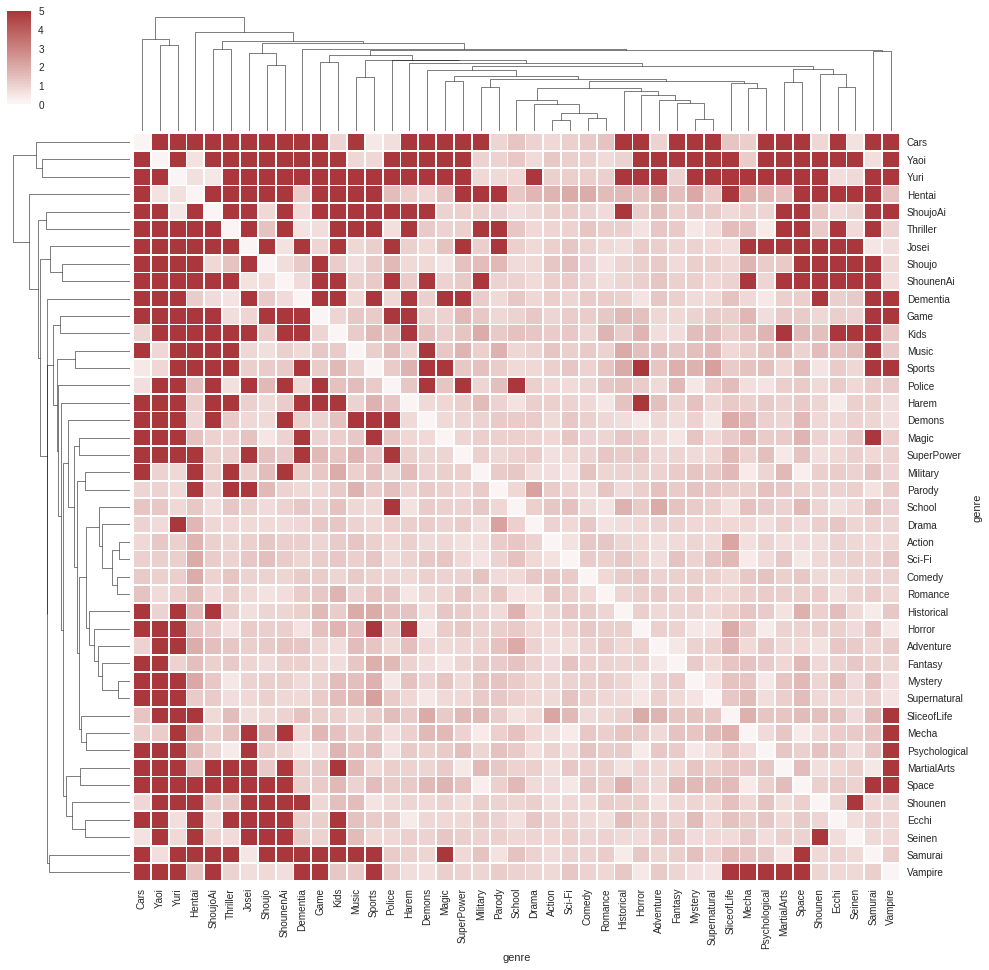

In [160]:
# using precomputed distance matrix https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matrix
dists = pdist(genres_animes, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 5
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_animes.index
dists_df.index = genres_animes.index

linkage = linkage(dists_m, method='average')

sns.clustermap(dists_df, center=0, cmap="vlag", row_linkage=linkage, col_linkage=linkage,
               linewidths=.75, figsize=(16, 16))